# Using Pycaret to analize Covid19 confirmed cases

This notebook aimed to apply Pycaret to the dataset of Covid19 confirmed cases by a subset of countries.
The plan of action is as follows:
* EDA by each country in order to understand its own time series 
* Build a 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.time_series import TSForecastingExperiment
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Import the complete confirmed cases for all countries
df_confirmed_global = pd.read_csv('data/time_series_covid19_confirmed_global.csv')

In [3]:
df_confirmed_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB


In [4]:
# Check the first 5 rows
df_confirmed_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [5]:
# Delete some columns that won't be usefull
df_confirmed_global.drop(columns=["Province/State", "Lat", "Long"], inplace=True)

In [6]:
# Check the countries from the dataframe
df_confirmed_global["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [7]:
# Create a subset with the information of some countries
countries = ['China', 'US', 'India', 'Germany', 'Colombia', 'Uruguay', 'Taiwan*']
df_confirmed_subset = df_confirmed_global[df_confirmed_global["Country/Region"].isin(countries)]
df_confirmed_subset.head(5)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
59,China,1,9,15,39,60,70,106,152,200,...,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275
60,China,14,22,36,41,68,80,91,111,114,...,40774,40774,40774,40774,40774,40774,40774,40774,40774,40774
61,China,6,9,27,57,75,110,132,147,182,...,14715,14715,14715,14715,14715,14715,14715,14715,14715,14715
62,China,1,5,10,18,35,59,80,84,101,...,17122,17122,17122,17122,17122,17122,17122,17122,17122,17122
63,China,0,2,2,4,7,14,19,24,26,...,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742


In [8]:
# It seems that the original dataframe was desaggregated by Lat and Long.
# Create a dataframe aggregating by country.
df_confirmed_subset = df_confirmed_subset.groupby(by = "Country/Region")\
                                         .agg('sum')\
                                         .reset_index()

In [9]:
# Check the first 5 rows
df_confirmed_subset.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,China,548,643,920,1406,2075,2877,5509,6087,8141,...,4903524,4903524,4903524,4903524,4903524,4903524,4903524,4903524,4903524,4903524
1,Colombia,0,0,0,0,0,0,0,0,0,...,6357173,6358232,6358232,6358232,6358232,6358232,6358232,6358232,6359093,6359093
2,Germany,0,0,0,0,0,1,4,4,4,...,38168908,38189954,38202571,38210850,38210850,38210851,38210851,38231610,38241231,38249060
3,India,0,0,0,0,0,0,0,0,1,...,44687837,44688105,44688388,44688722,44689046,44689327,44689593,44689919,44690298,44690738
4,Taiwan*,1,1,3,3,4,5,8,8,9,...,9970937,9970937,9970937,9970937,9970937,9970937,9970937,9970937,9970937,9970937


In [10]:
# Change the columns of dates into the index
# Change the values of the Countr/Region column into columns
df_confirmed_subset = df_confirmed_subset.melt(id_vars=['Country/Region'], var_name='date', value_name='value')
df_confirmed_subset['date'] = pd.to_datetime(df_confirmed_subset['date'])
df_confirmed_subset = df_confirmed_subset.pivot(index='date', columns='Country/Region', values='value')

# Check the result
df_confirmed_subset.head()

Country/Region,China,Colombia,Germany,India,Taiwan*,US,Uruguay
date,,,,,,,
2020-01-22,548,0,0,0,1,1,0
2020-01-23,643,0,0,0,1,1,0
2020-01-24,920,0,0,0,3,2,0
2020-01-25,1406,0,0,0,3,2,0
2020-01-26,2075,0,0,0,4,5,0


In [11]:
df_confirmed_subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2020-01-22 to 2023-03-09
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   China     1143 non-null   int64
 1   Colombia  1143 non-null   int64
 2   Germany   1143 non-null   int64
 3   India     1143 non-null   int64
 4   Taiwan*   1143 non-null   int64
 5   US        1143 non-null   int64
 6   Uruguay   1143 non-null   int64
dtypes: int64(7)
memory usage: 71.4 KB


In [12]:

df_confirmed_subset.reset_index(inplace = True)
df_confirmed_subset['date'] = pd.to_datetime(df_confirmed_subset['date'])
df_confirmed_subset.set_index('date', inplace=True)
df_confirmed_subset.dropna(inplace=True)

In [13]:
# Change the dataset into daily new confirmed cases 
df_confirmed_subset = df_confirmed_subset.diff(periods=1).dropna()

df_confirmed_subset.head()

Country/Region,China,Colombia,Germany,India,Taiwan*,US,Uruguay
date,,,,,,,
2020-01-23,95.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,277.0,0.0,0.0,0.0,2.0,1.0,0.0
2020-01-25,486.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,669.0,0.0,0.0,0.0,1.0,3.0,0.0
2020-01-27,802.0,0.0,1.0,0.0,1.0,0.0,0.0


### Feature creation
Define a function to create different features based on time series index 

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [15]:
# Apply the function to the dataset
df_confirmed_subset = create_features(df_confirmed_subset)

df_confirmed_subset.head()

Country/Region,China,Colombia,Germany,India,Taiwan*,US,Uruguay,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,,,
2020-01-23,95.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,1,2020,23,23,4
2020-01-24,277.0,0.0,0.0,0.0,2.0,1.0,0.0,4,1,1,2020,24,24,4
2020-01-25,486.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,1,2020,25,25,4
2020-01-26,669.0,0.0,0.0,0.0,1.0,3.0,0.0,6,1,1,2020,26,26,4
2020-01-27,802.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,1,2020,27,27,5


## Analyze features and target (confirmed cases) relationships

In [34]:
# Create a function to generate and display histograms depicting daily confirmed cases for each country
def hist_by_country(df, countries, x_range=(0, 1000)):
    num_columns = 2
    num_rows = len(countries) // num_columns + (len(countries) % num_columns > 0)
    
    # Create subplots for each country with shared y-axis
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(12, 6 * num_rows), sharey=True)

    for i, country in enumerate(countries):
        # Calculate the position in the subplot grid
        row_position = i // num_columns
        col_position = i % num_columns
        
        # Select the country
        selected_country = df.loc[:, country]
        
        # Create a histogram for Confirmed cases in the current subplot
        selected_country.plot(kind='hist', bins=50, ax=axes[row_position, col_position], range=x_range)
        axes[row_position, col_position].set_title(f'{country} - Confirmed cases')

    # Remove empty subplots
    for i in range(len(countries), num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


### seasonal_decompose
Use seasonal_decompose to decomposes the time series into trend, seasonal, and residual components using a method based on LOESS (locally estimated scatterplot smoothing).

In [98]:
def plot_seasonal_decompose(df, country):
    # Select both the time feature and the specified column for the country
    selected_columns_loc = df.loc[:, country]

    result = seasonal_decompose(selected_columns_loc, model="additive")

    # Extract individual components
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Plot the individual components
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(df.iloc[:, 0], label='Original')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residual')
    plt.legend()

    # Adjust layout to make room for suptitle
    plt.subplots_adjust(top=0.9)

    # Add suptitle
    plt.suptitle(f'{country} - Decomposition of Time Series', y=0.98)

    plt.tight_layout()
    plt.show()

### Fourier Transforms
Using Fourier Transforms (scipy.fft) in order to analyze trend

In [89]:
def plot_fft_decompose(df, country):
    # Select both the time feature and the specified column for the country
    selected_columns_loc = df.loc[:, country]
    
    fft_result = np.fft.fft(selected_columns_loc)
 
    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(np.abs(fft_result))
    plt.suptitle(f'{country} - FFT Result')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    
    
    plt.tight_layout()
    plt.show()

## All countries

China, Uruguay, Germany, Colombia, and India exhibit a pronounced left tail in their histograms, indicating that the majority of daily confirmed cases are of a small magnitude. In contrast, the United States displays a smoother histogram, suggesting that its daily confirmed cases tend to be higher on average.

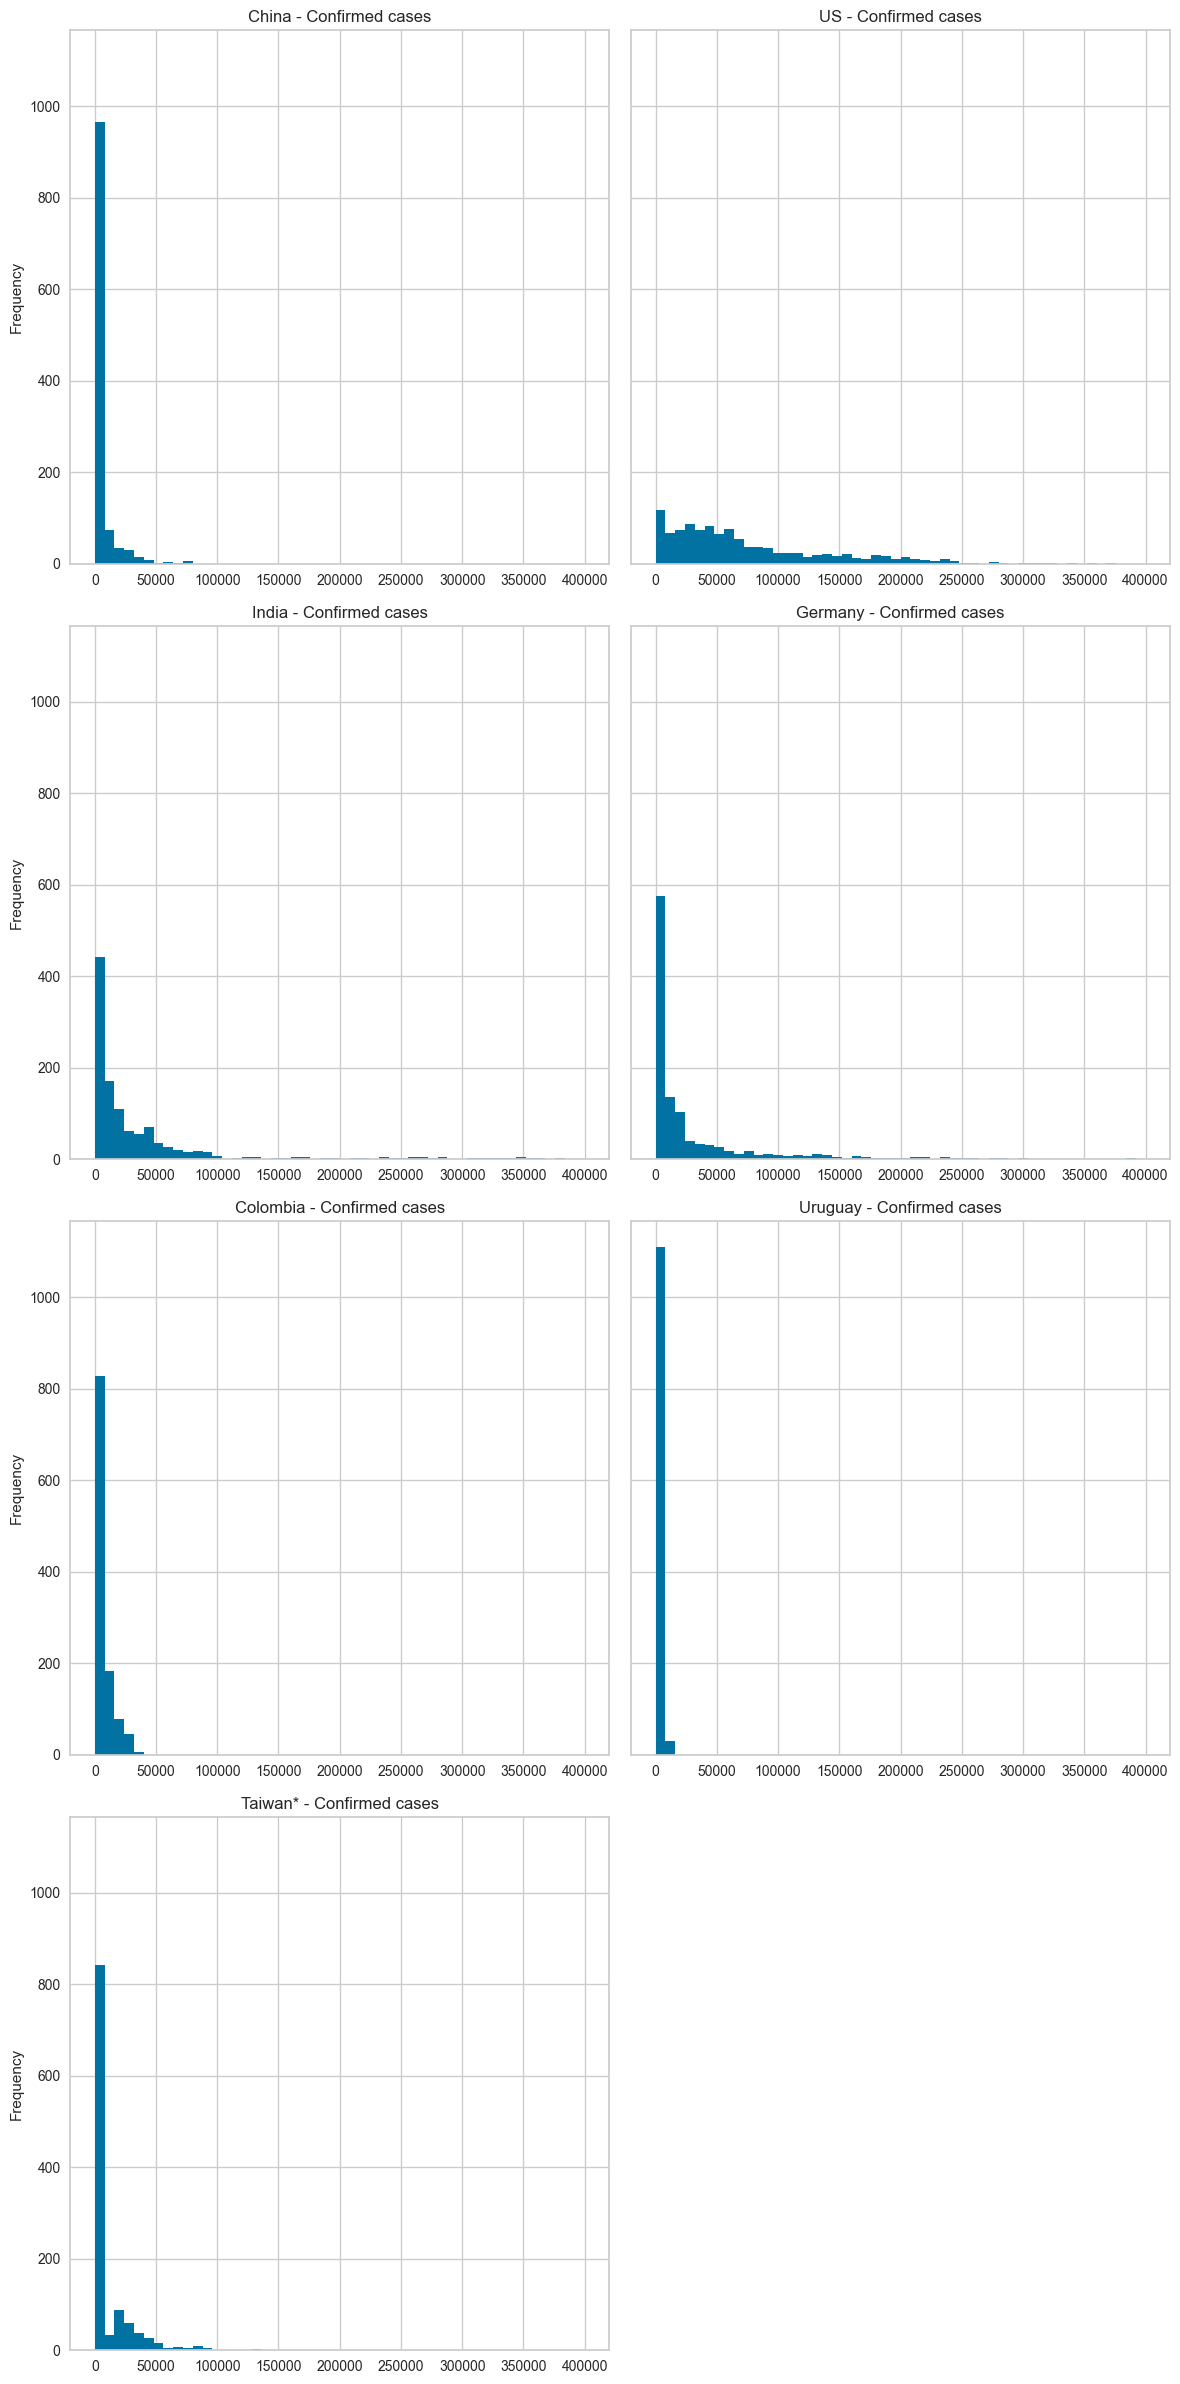

In [62]:
hist_by_country(df_confirmed_subset, countries, x_range=(0, 400000))


In [63]:
# Create a function to generate and display boxplot depicting confirmed cases for each country and time feature
def box_plot_by_country_feature(df, country):
    time_features = ['dayofweek', 
                     'quarter', 
                     'month', 
                     'year', 
                     'dayofyear', 
                     'dayofmonth', 
                     'weekofyear']
    num_columns = 2
    num_rows = len(time_features) // num_columns + (len(time_features) % num_columns > 0)

    # Create subplots for each time feature
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(12, 6 * num_rows))

    for i, time_feature in enumerate(time_features):
        # Calculate the position in the subplot grid
        row_position = i // num_columns
        col_position = i % num_columns

        # Select both the time feature and the specified column for the country
        selected_columns_loc = df.loc[:, [country, time_feature]]

        # Create a box plot for Confirmed cases in the current subplot
        sns.boxplot(data=selected_columns_loc, x=time_feature, y=country, ax=axes[row_position, col_position])
        axes[row_position, col_position].set_title(f'{country} - Confirmed cases by {time_feature}')

    # Remove empty subplots
    for i in range(len(time_features), num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

### China 
#### Boxplots by time feature

Seasonality is observed when analyzing the time series by day of month and week of year

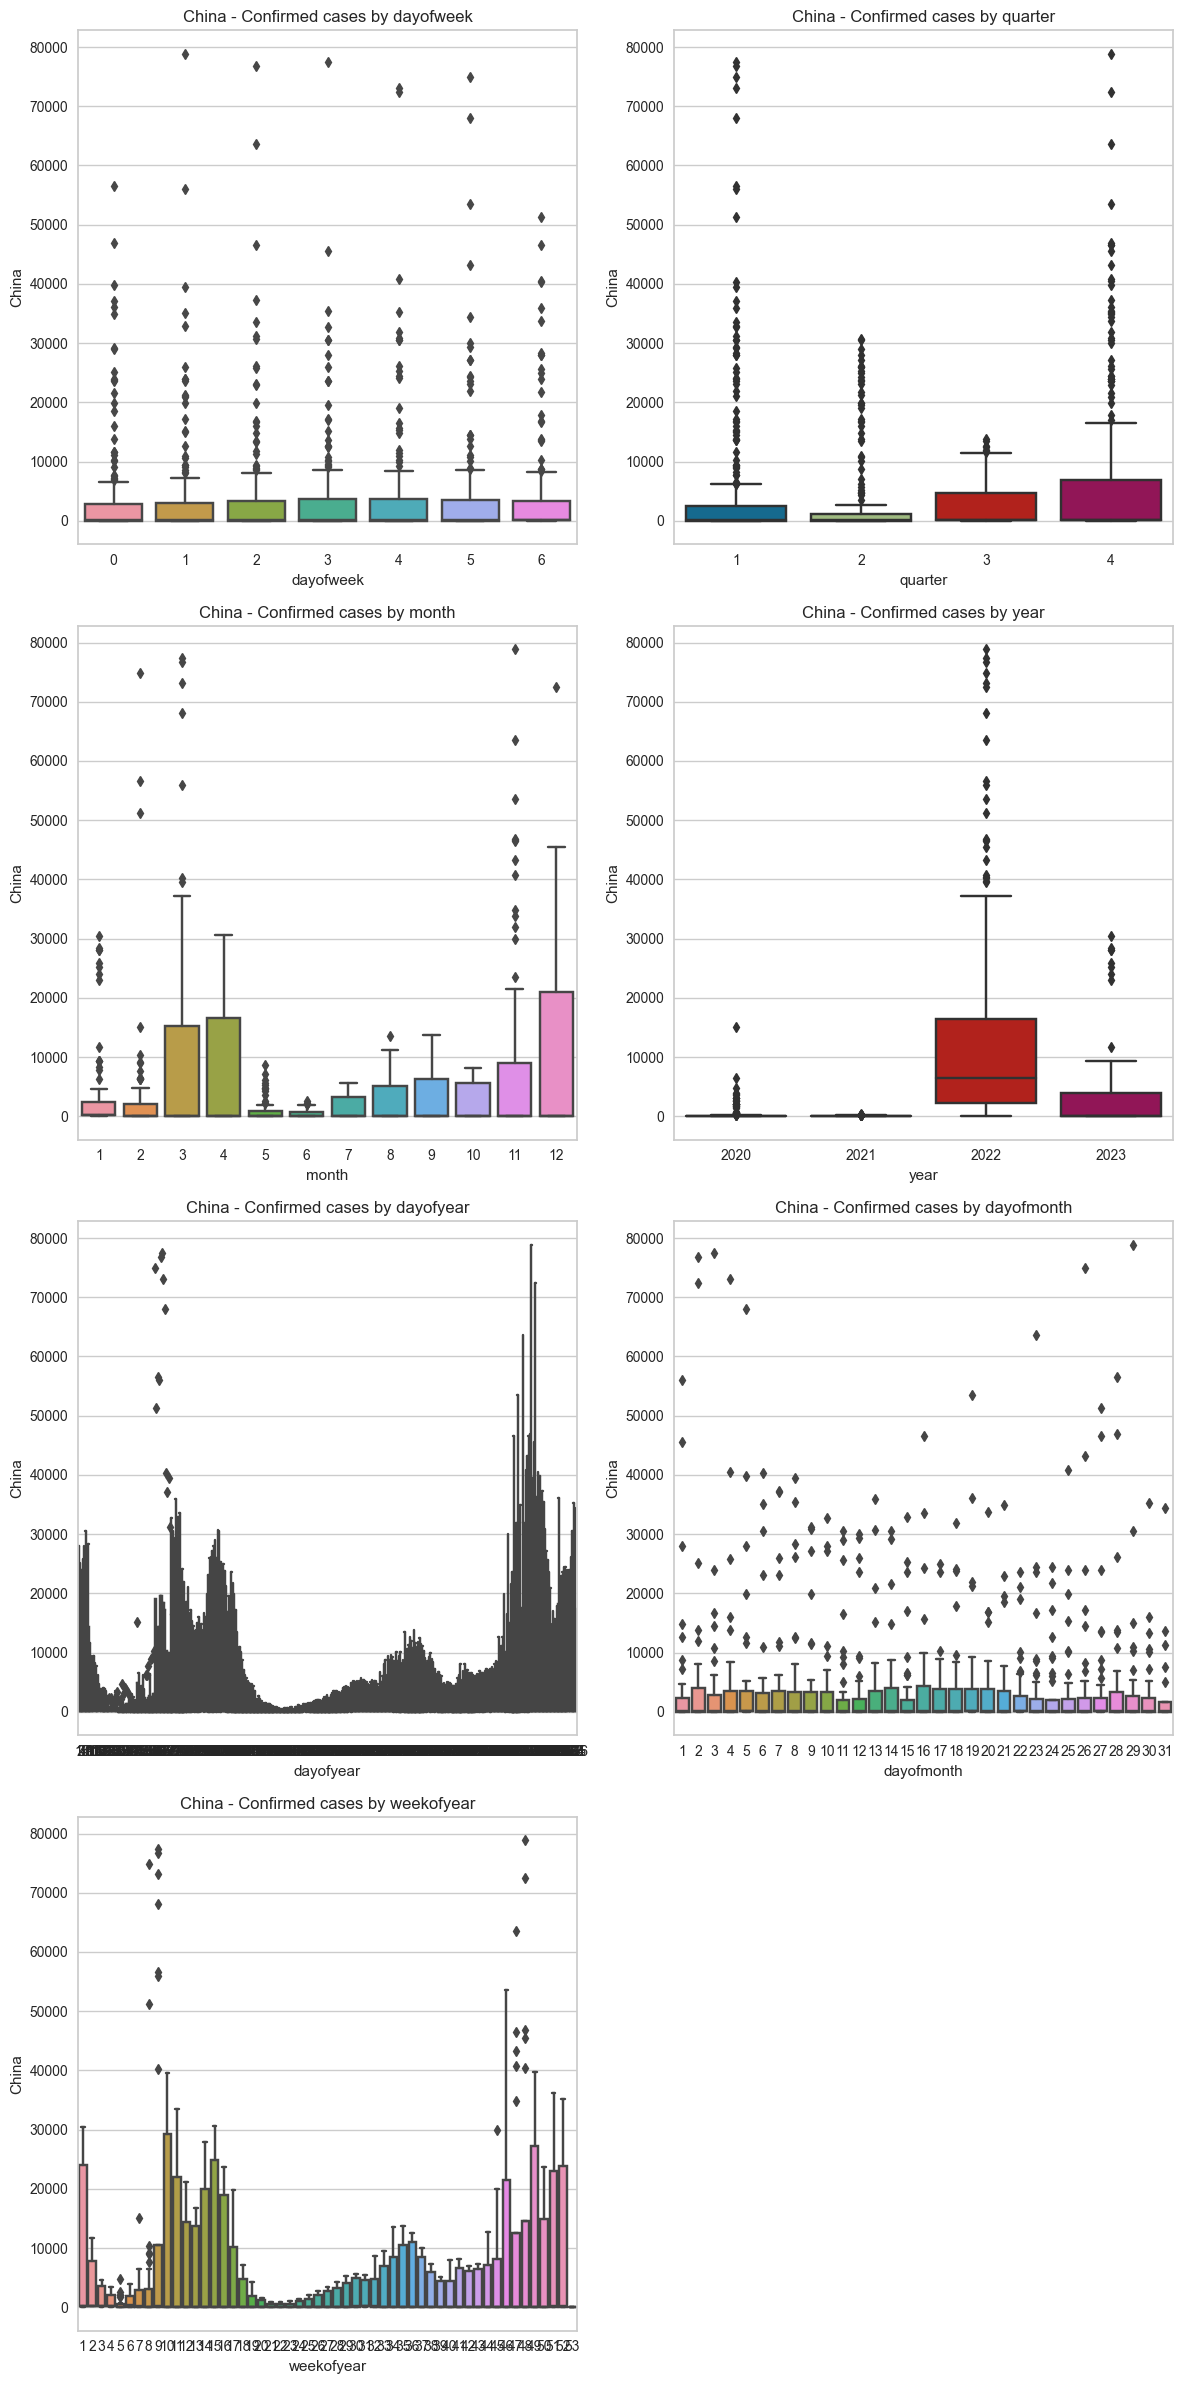

In [54]:
box_plot_by_country_feature(df_confirmed_subset, 'China')

#### Seasonal decompose

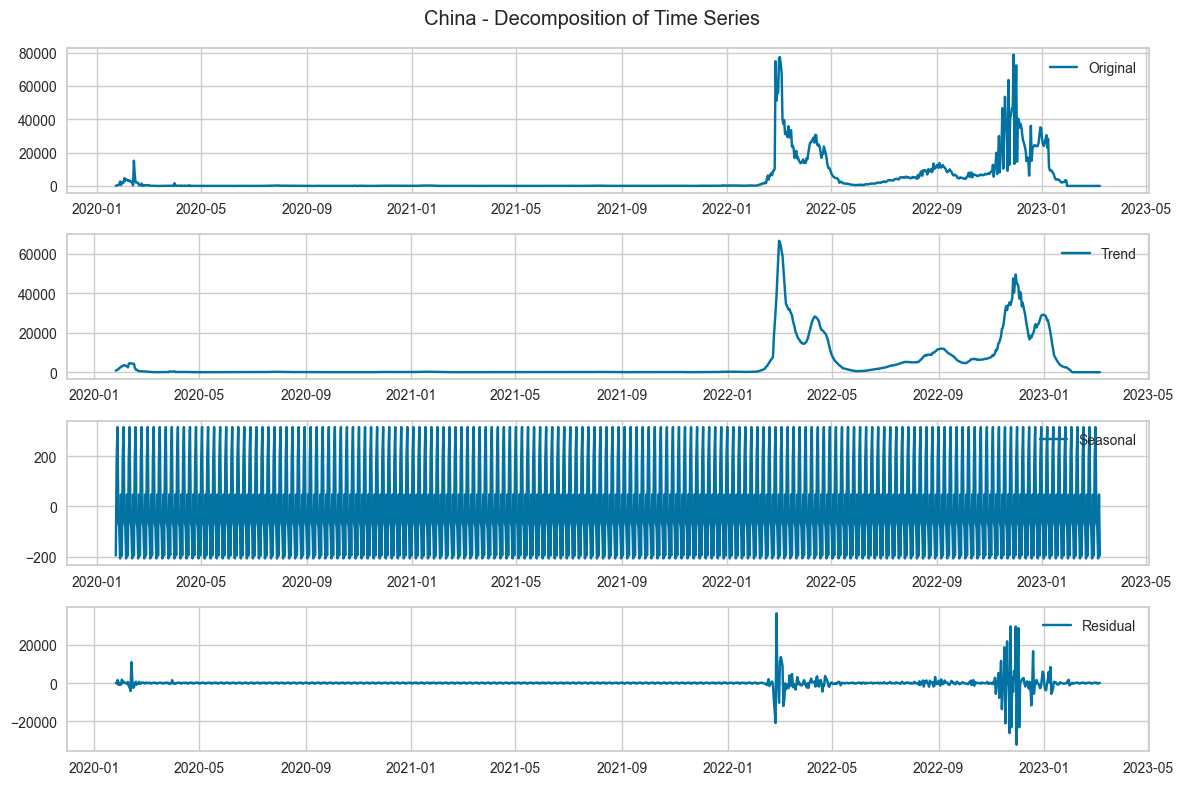

In [99]:
plot_seasonal_decompose(df_confirmed_subset, 'China')

#### Fourier Transforms

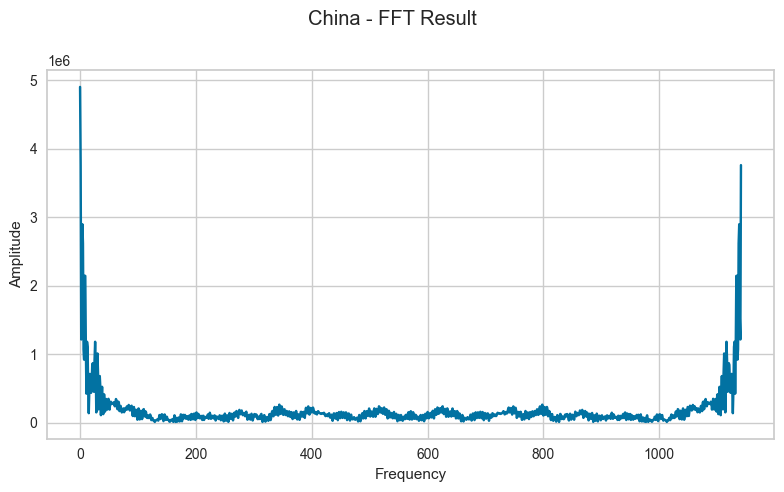

In [90]:
plot_fft_decompose(df_confirmed_subset, 'China')

### United States
#### Boxplots by time feature

The series displays notable seasonality over the course of month.

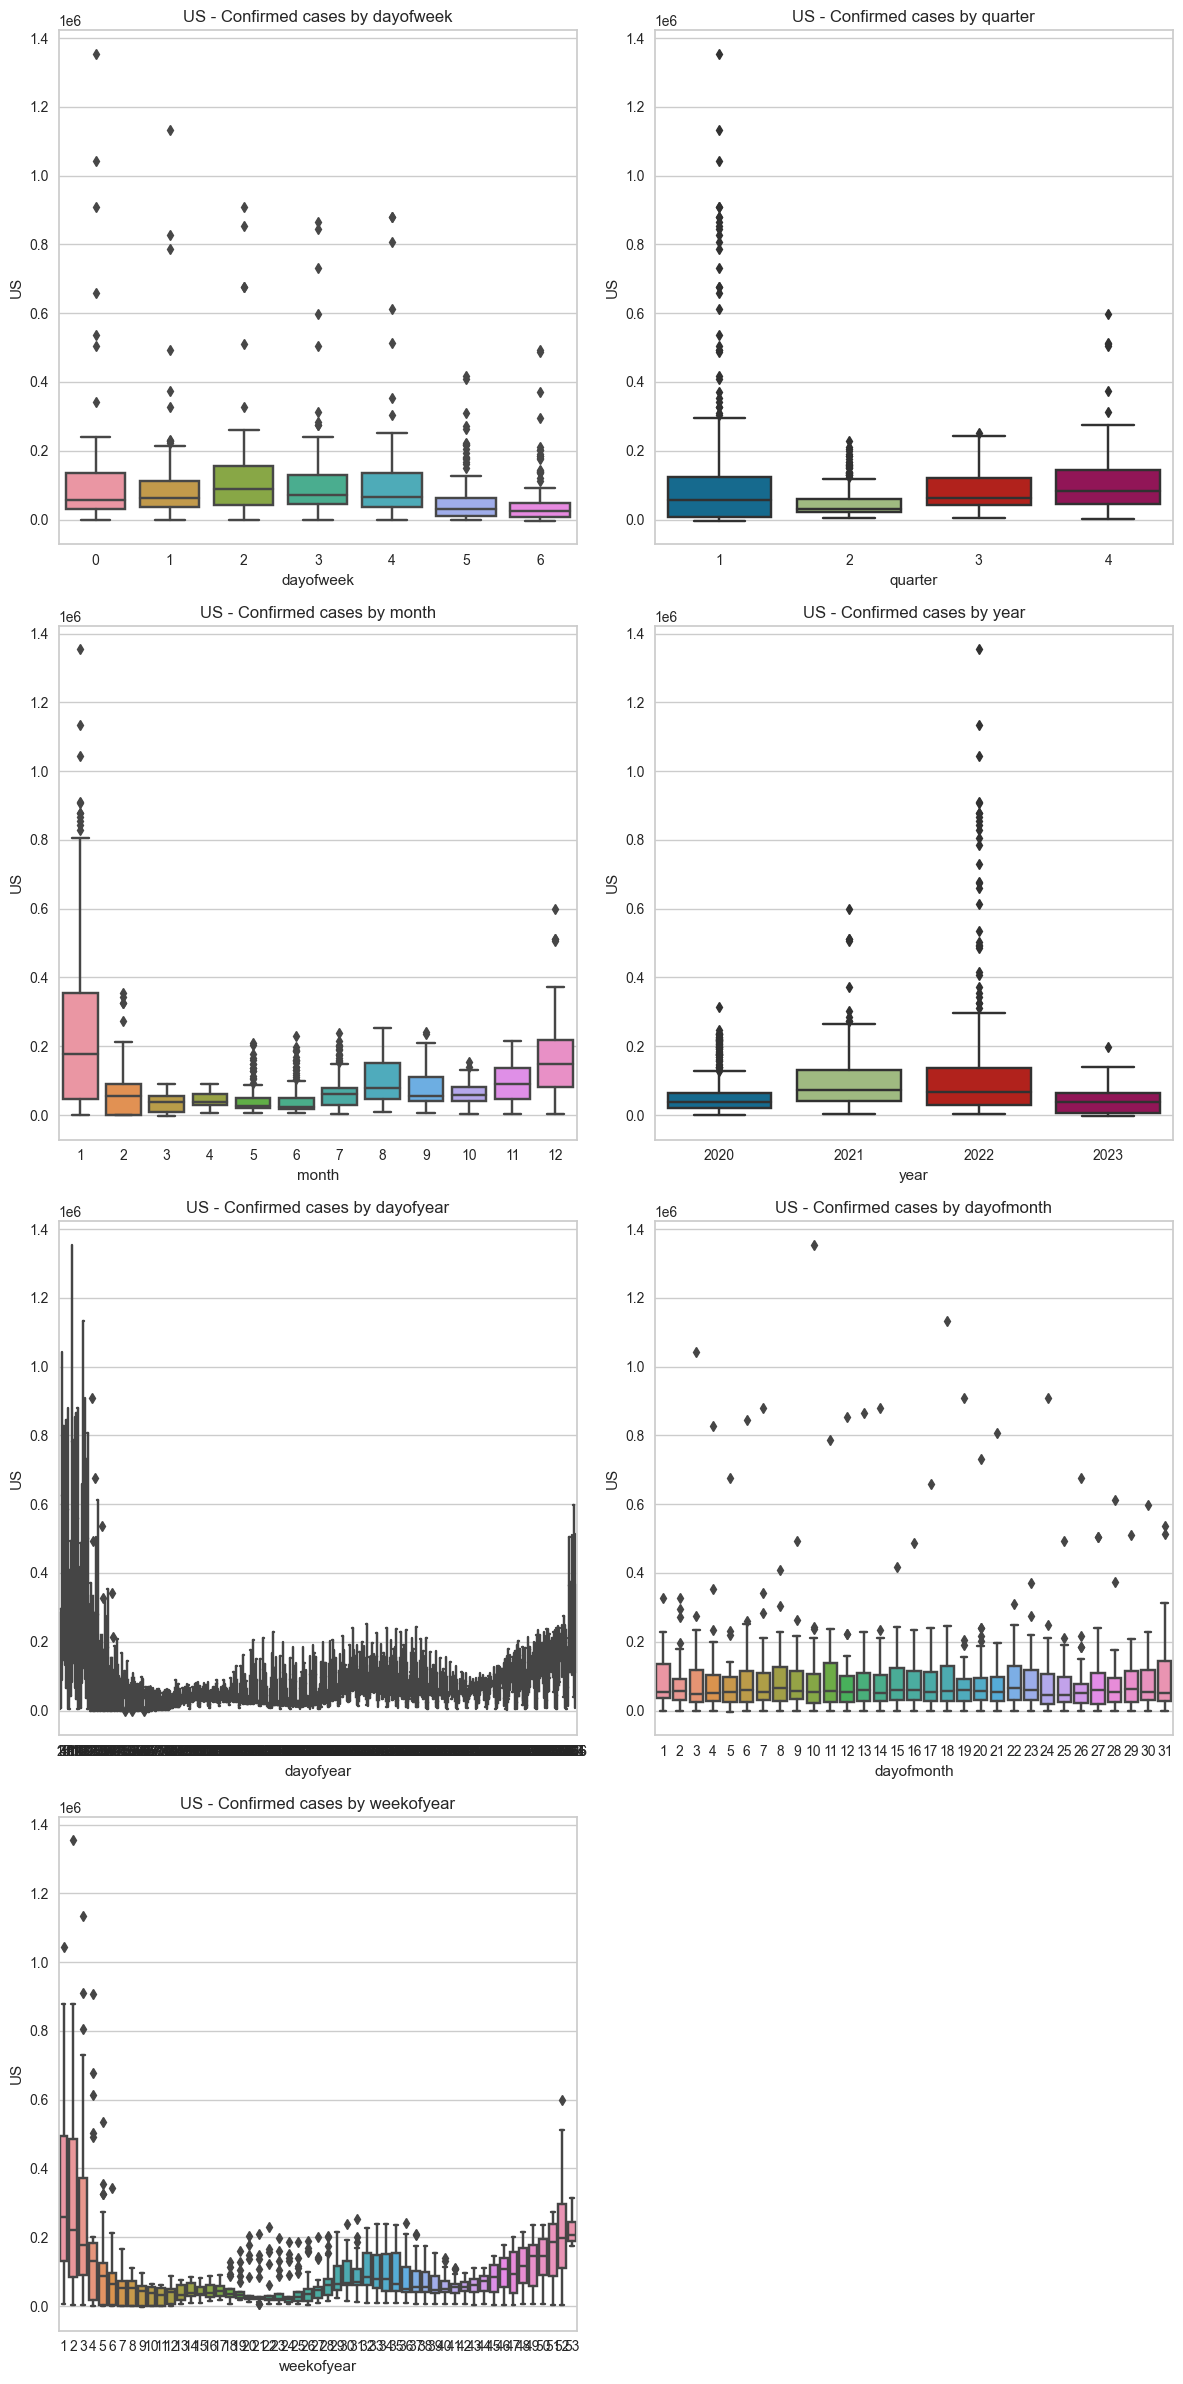

In [64]:
box_plot_by_country_feature(df_confirmed_subset, 'US')

#### Seasonal decompose

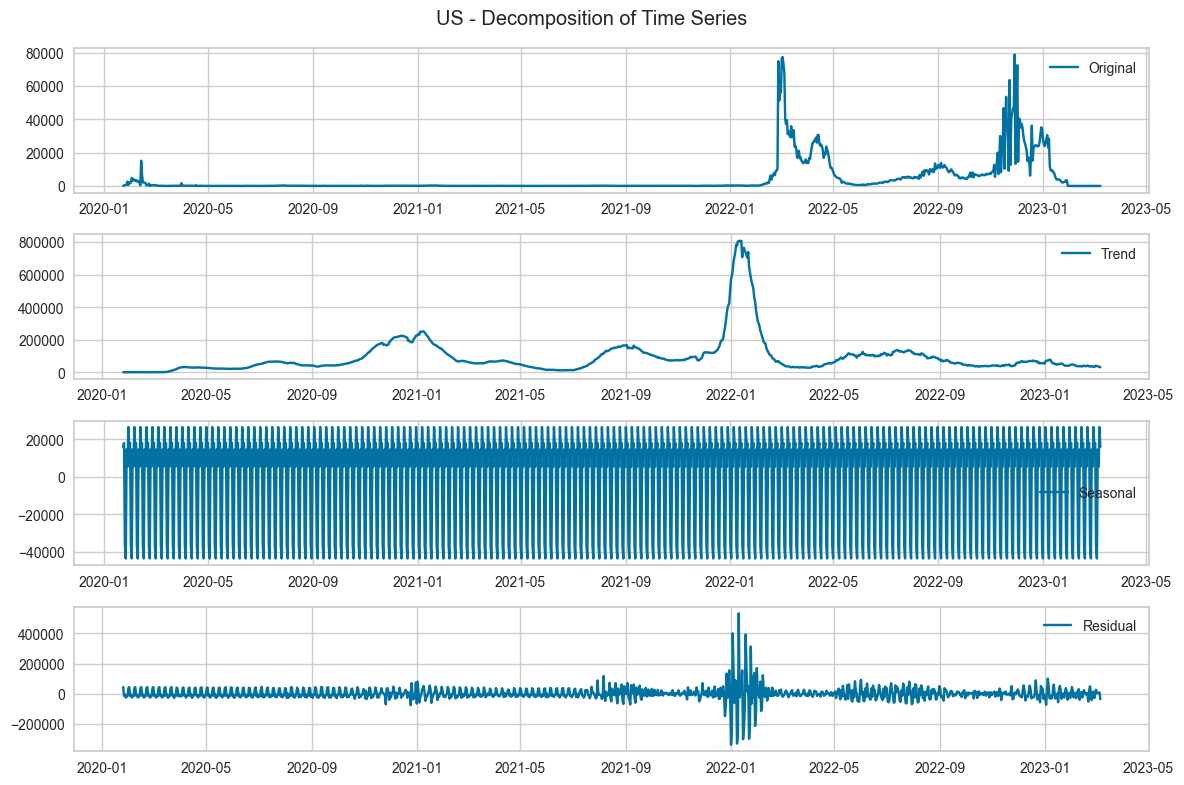

In [105]:
plot_seasonal_decompose(df_confirmed_subset, 'US')

#### Fourier Transforms

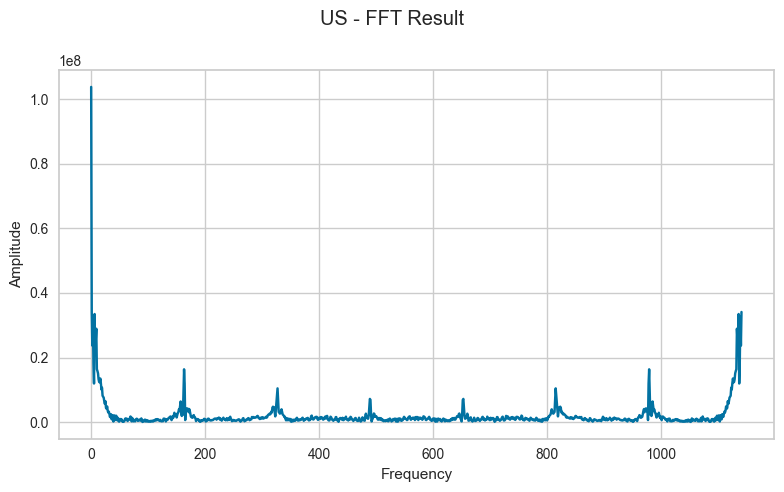

In [91]:
plot_fft_decompose(df_confirmed_subset, 'US')

### India
#### Boxplots by time feature
It appears to exhibit seasonality when the series is presented by the day of the month. However, there are still numerous outliers that could impact other time features.

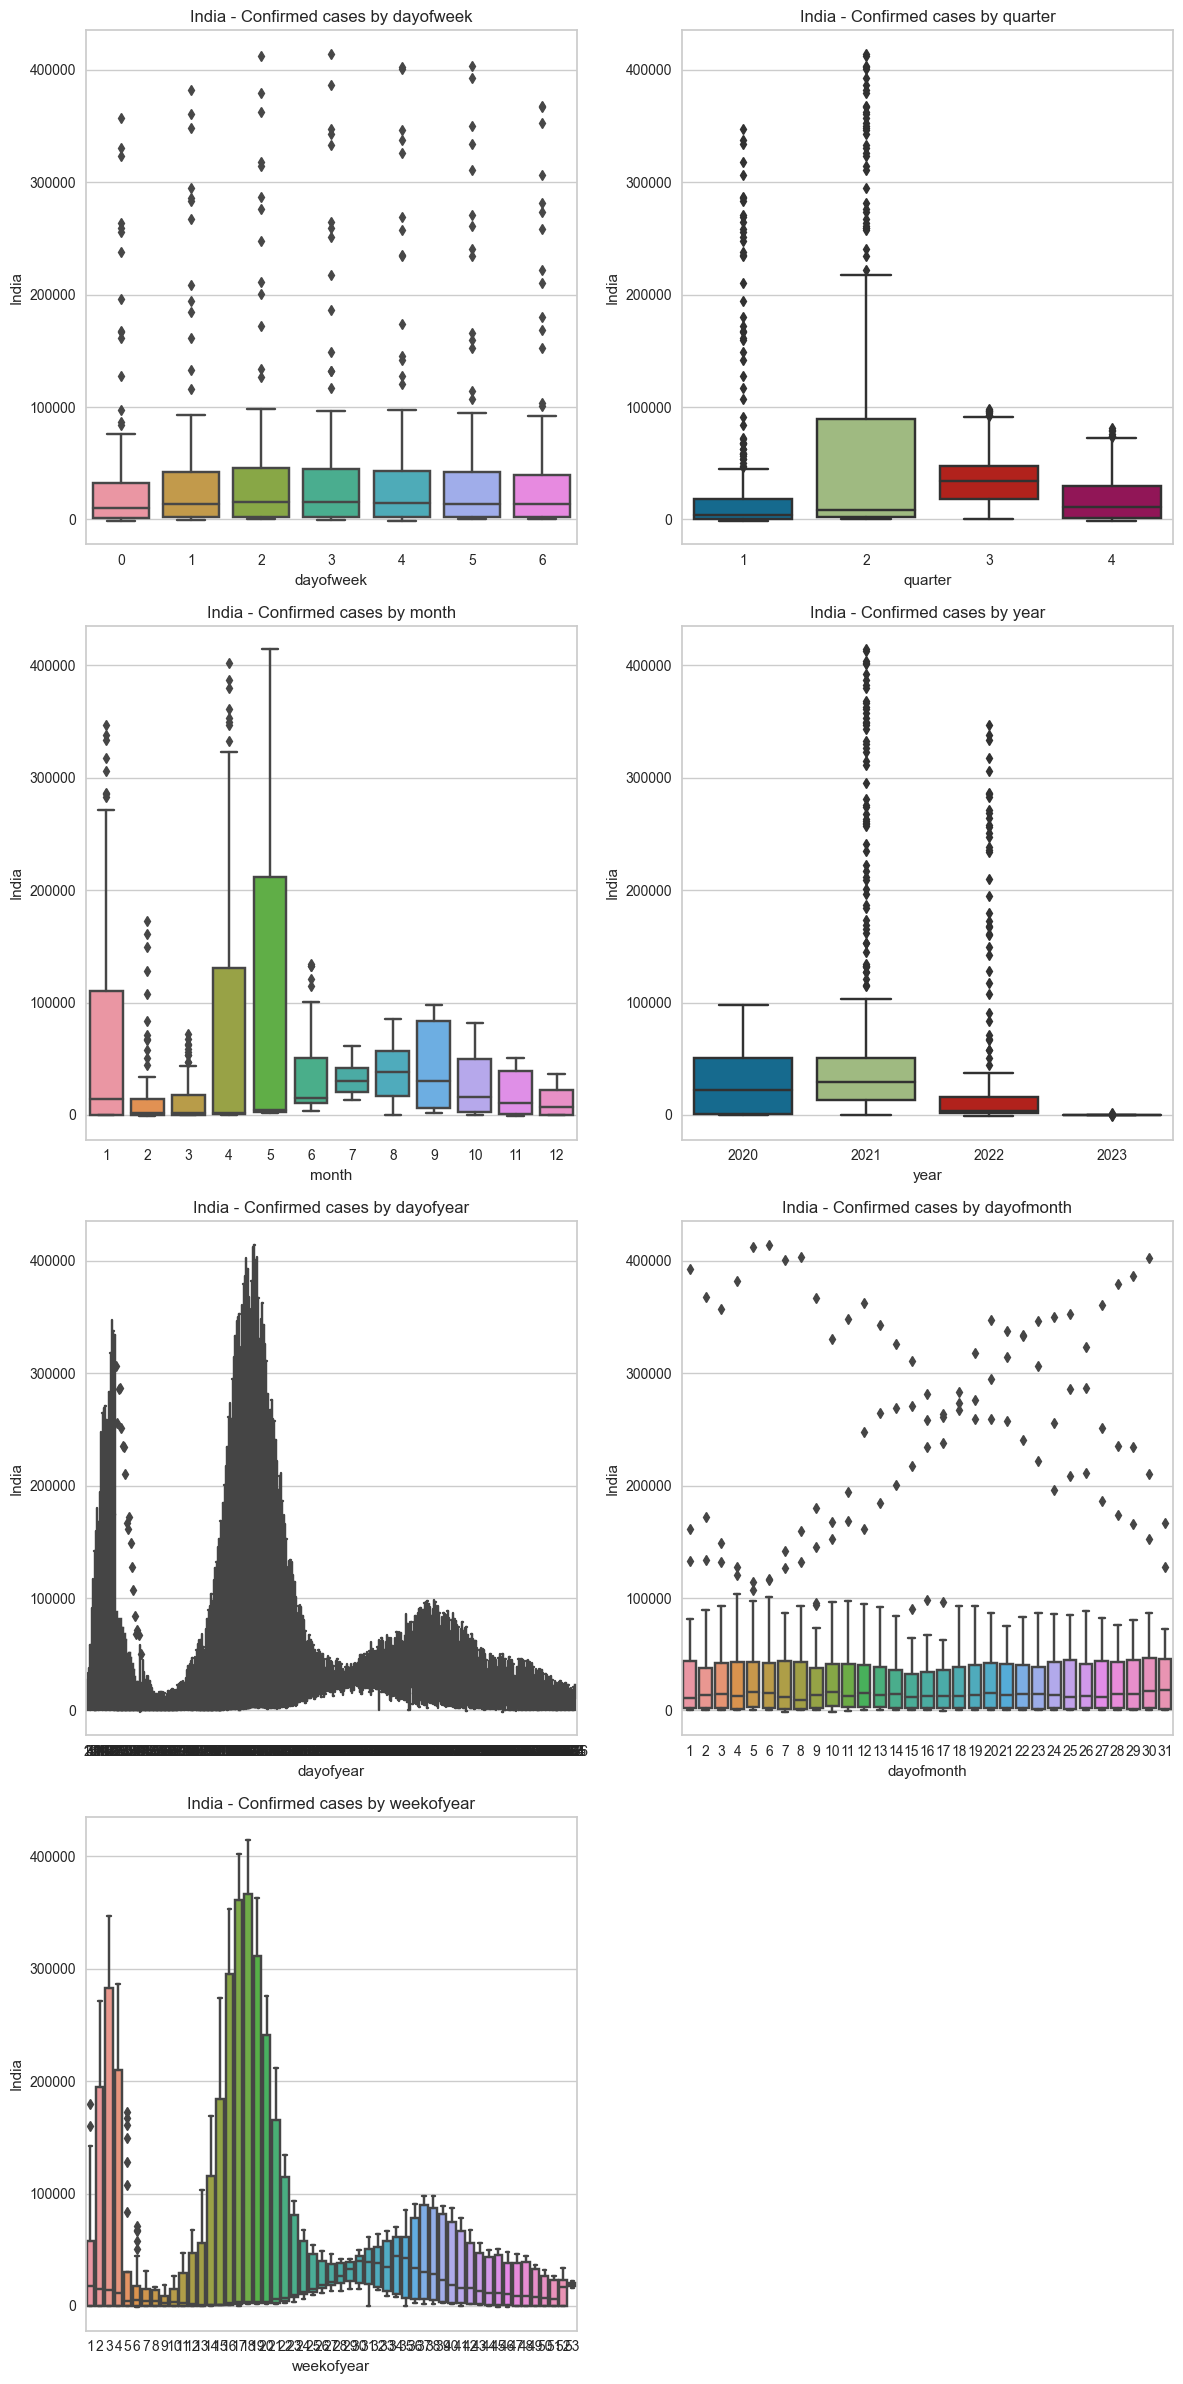

In [65]:
box_plot_by_country_feature(df_confirmed_subset, 'India')

#### Seasonal decompose

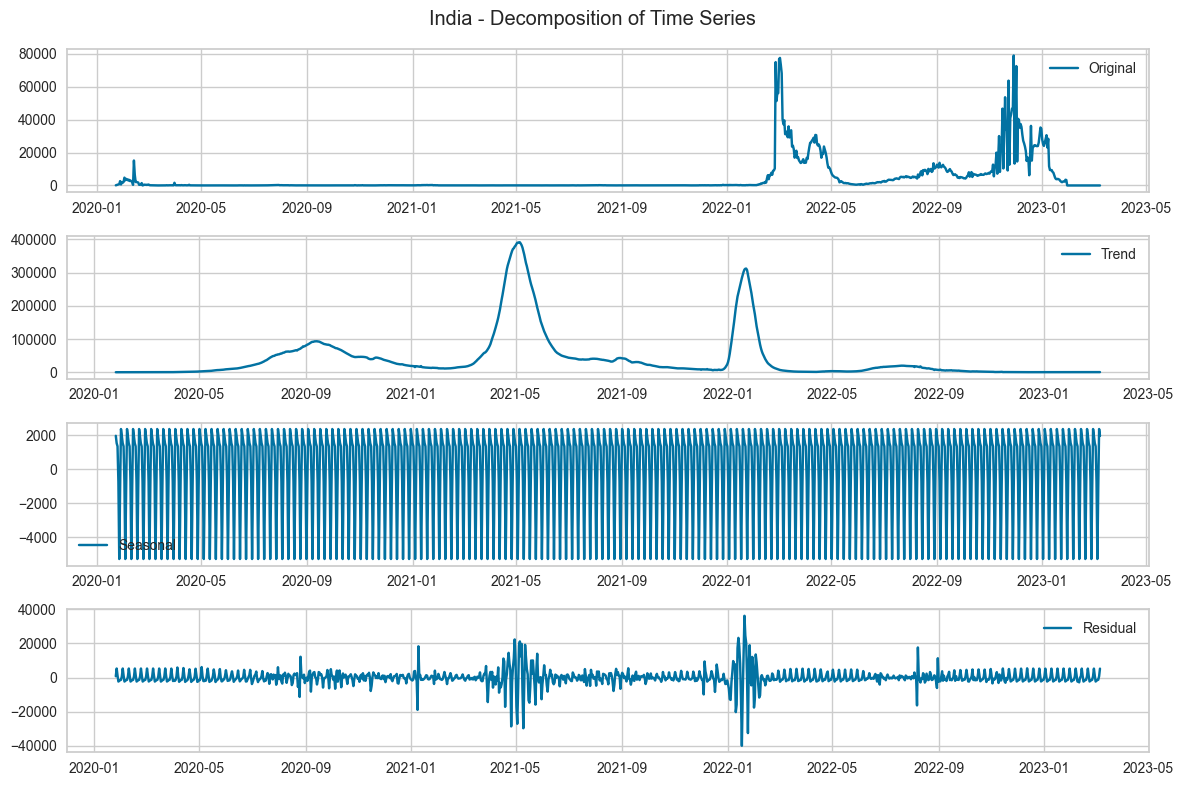

In [104]:
plot_seasonal_decompose(df_confirmed_subset, 'India')

#### Fourier Transforms

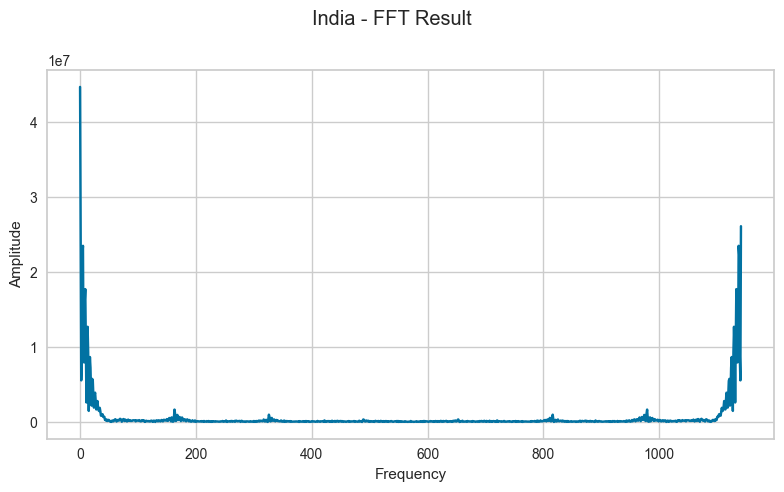

In [92]:
plot_fft_decompose(df_confirmed_subset, 'India')

### Germany
#### Boxplots by time feature

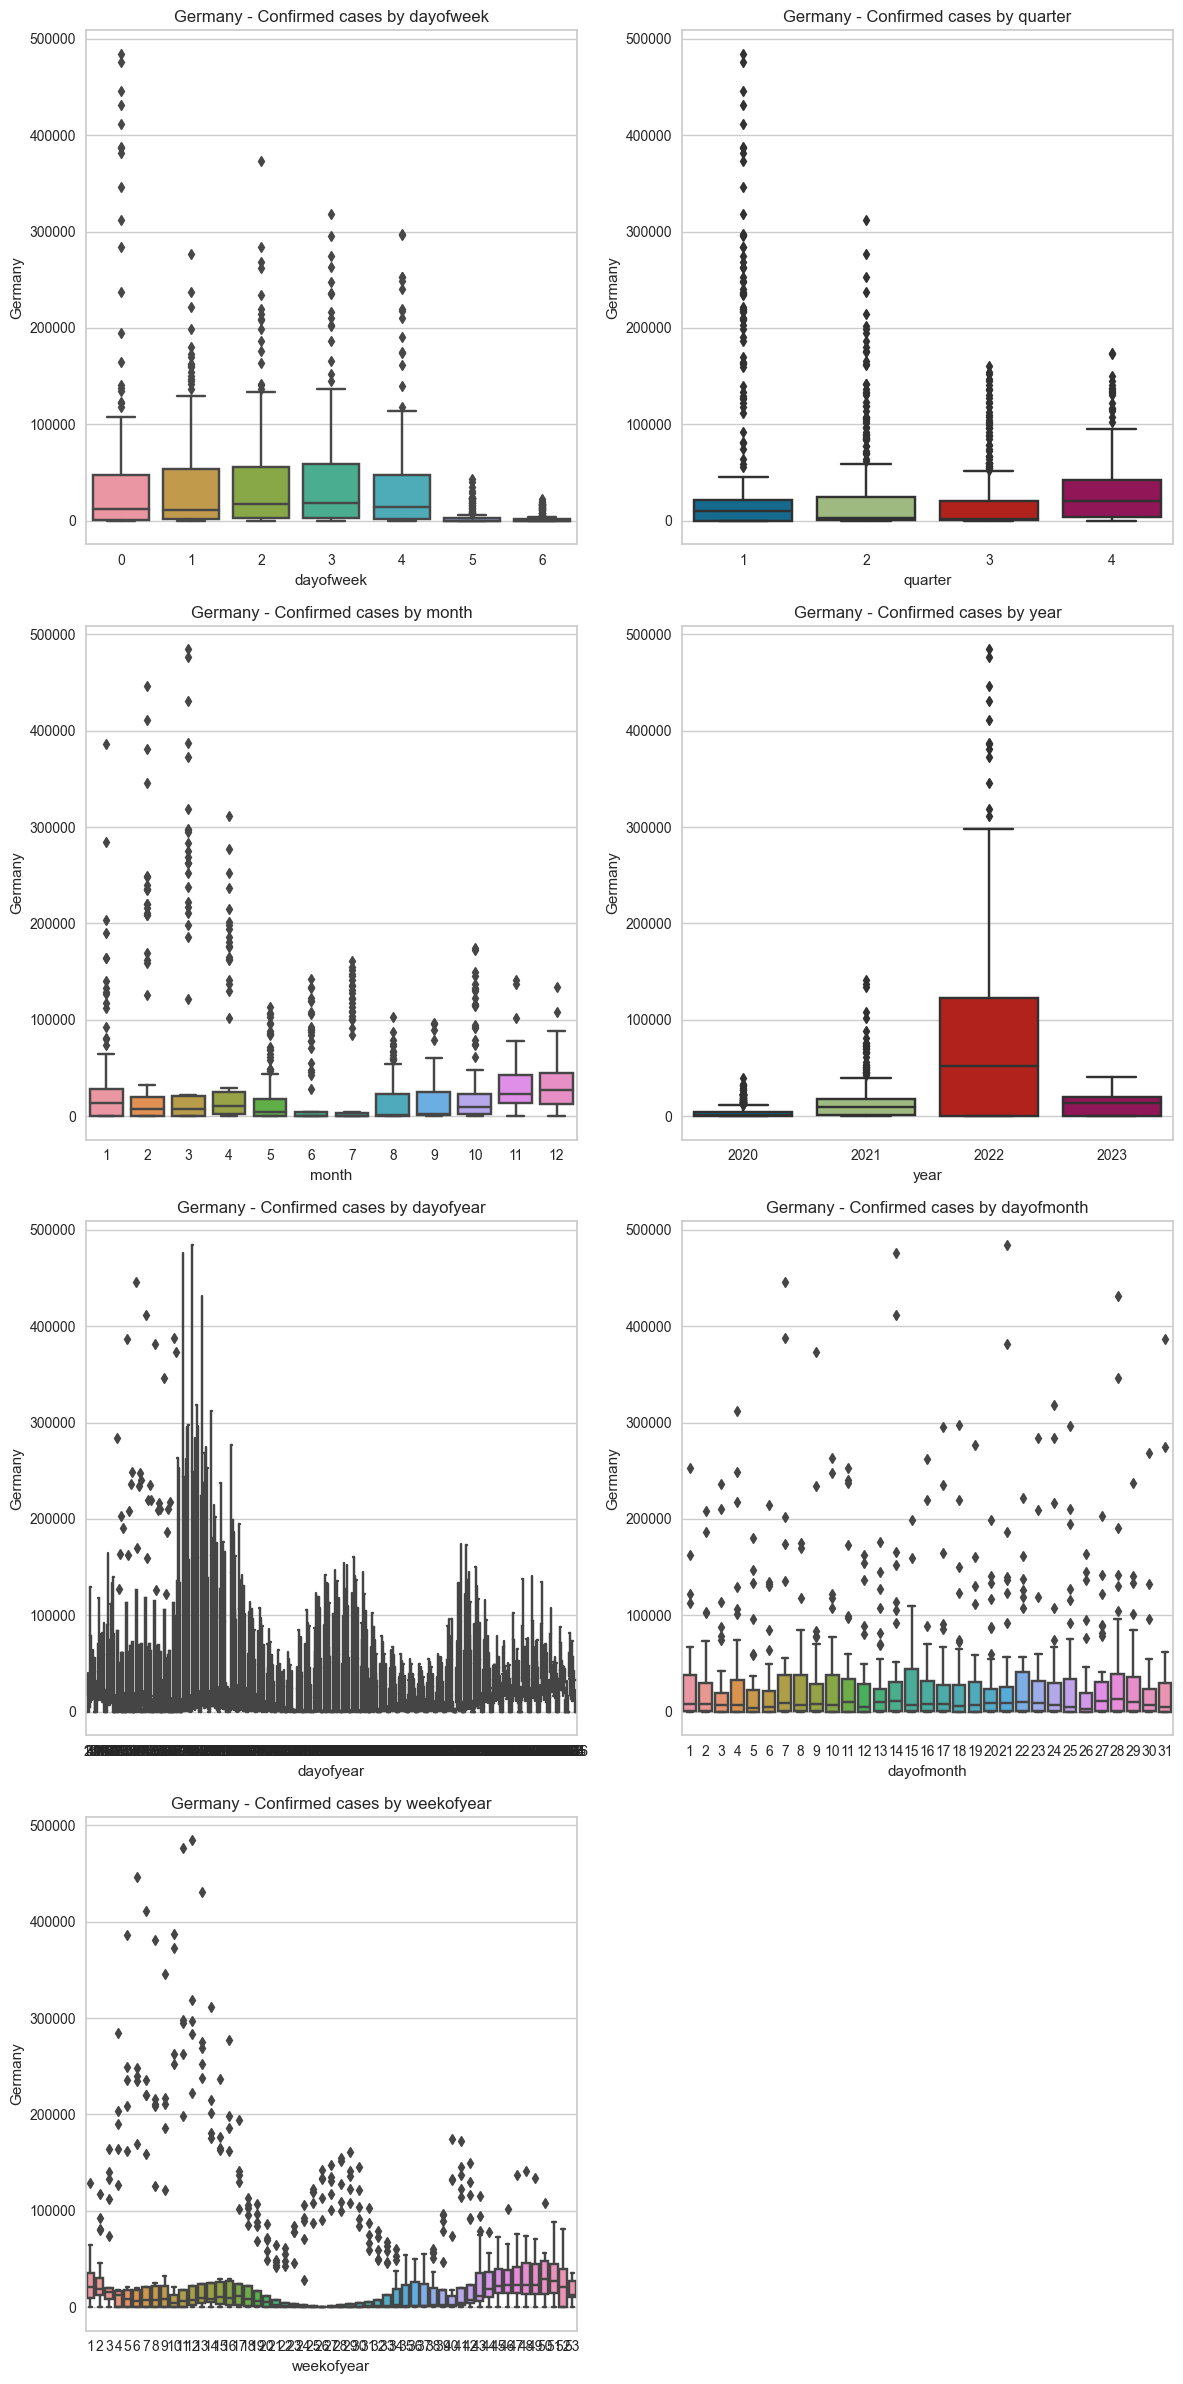

In [66]:
box_plot_by_country_feature(df_confirmed_subset, 'Germany')

#### Seasonal decompose

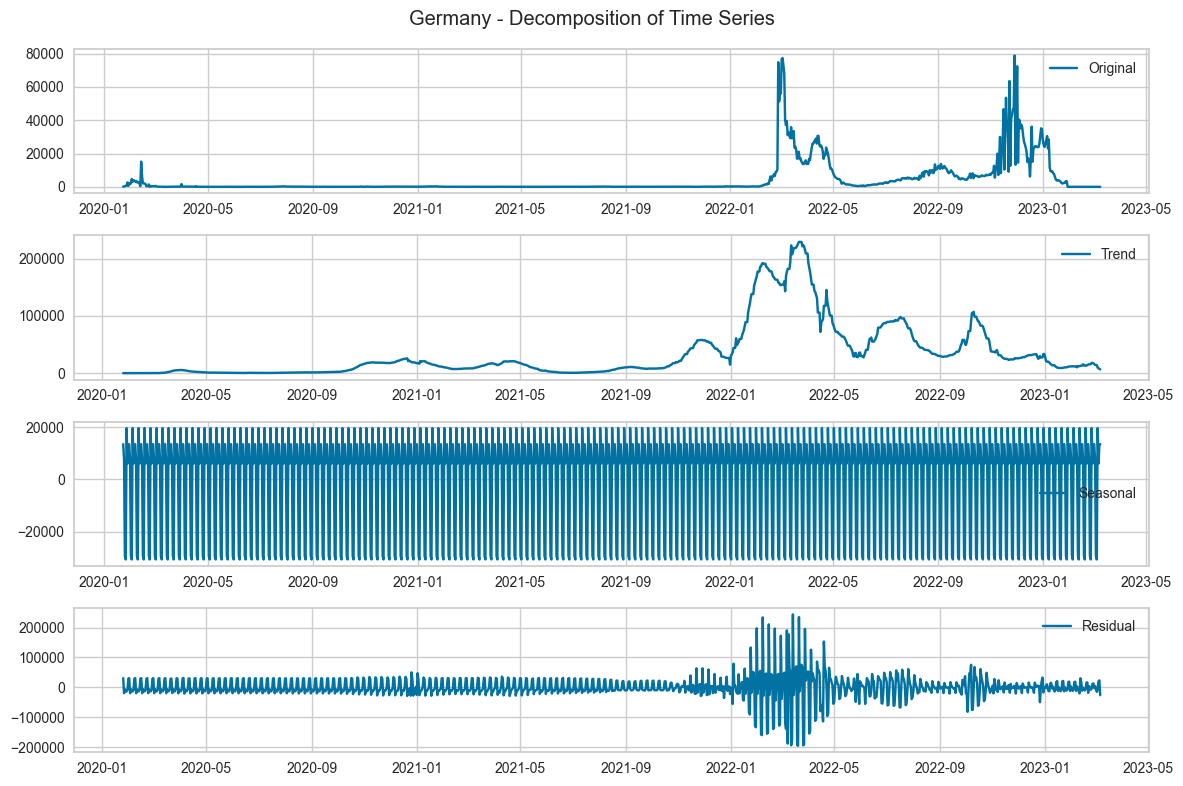

In [103]:
plot_seasonal_decompose(df_confirmed_subset, 'Germany')

#### Fourier Transforms

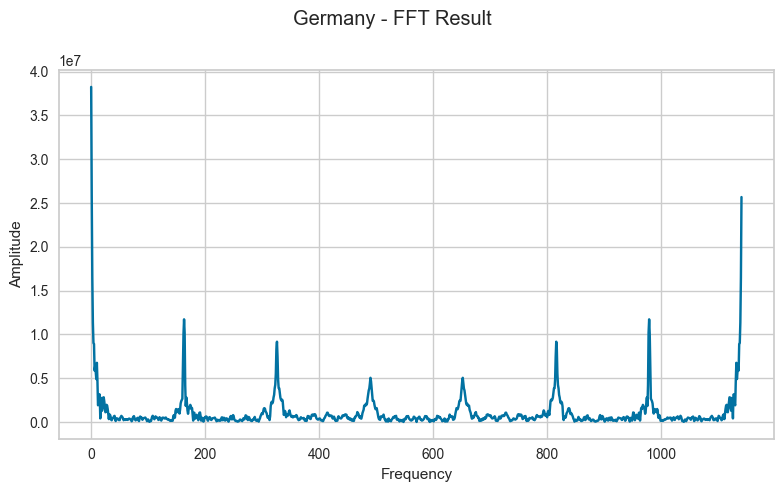

In [93]:
plot_fft_decompose(df_confirmed_subset, 'Germany')

### Colombia 
#### Boxplots by time feature

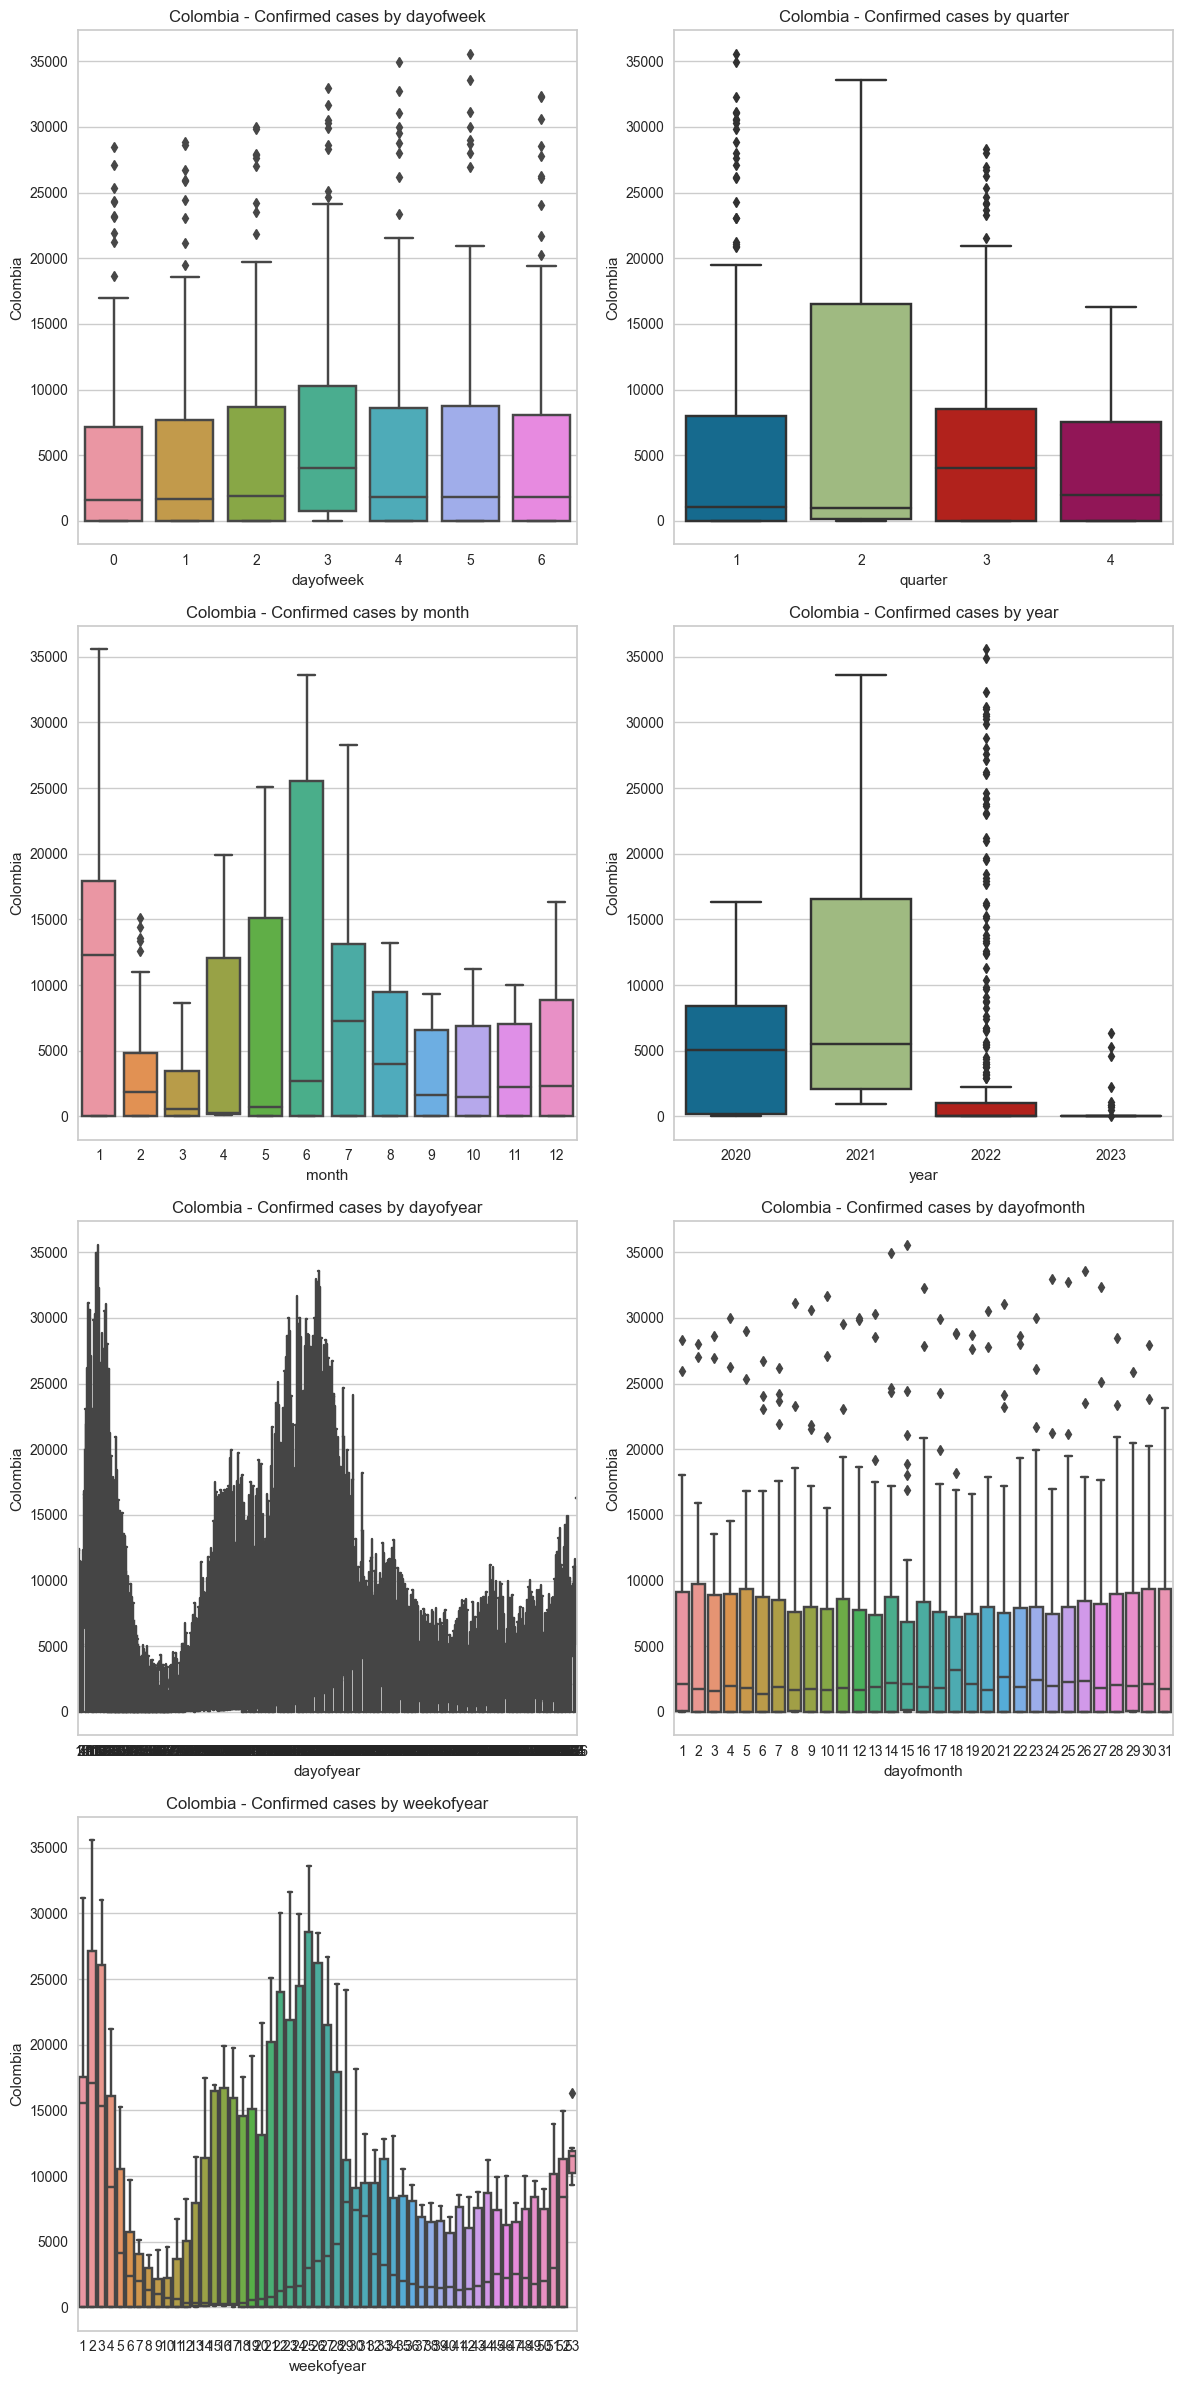

In [106]:
box_plot_by_country_feature(df_confirmed_subset, 'Colombia')

#### Seasonal decompose

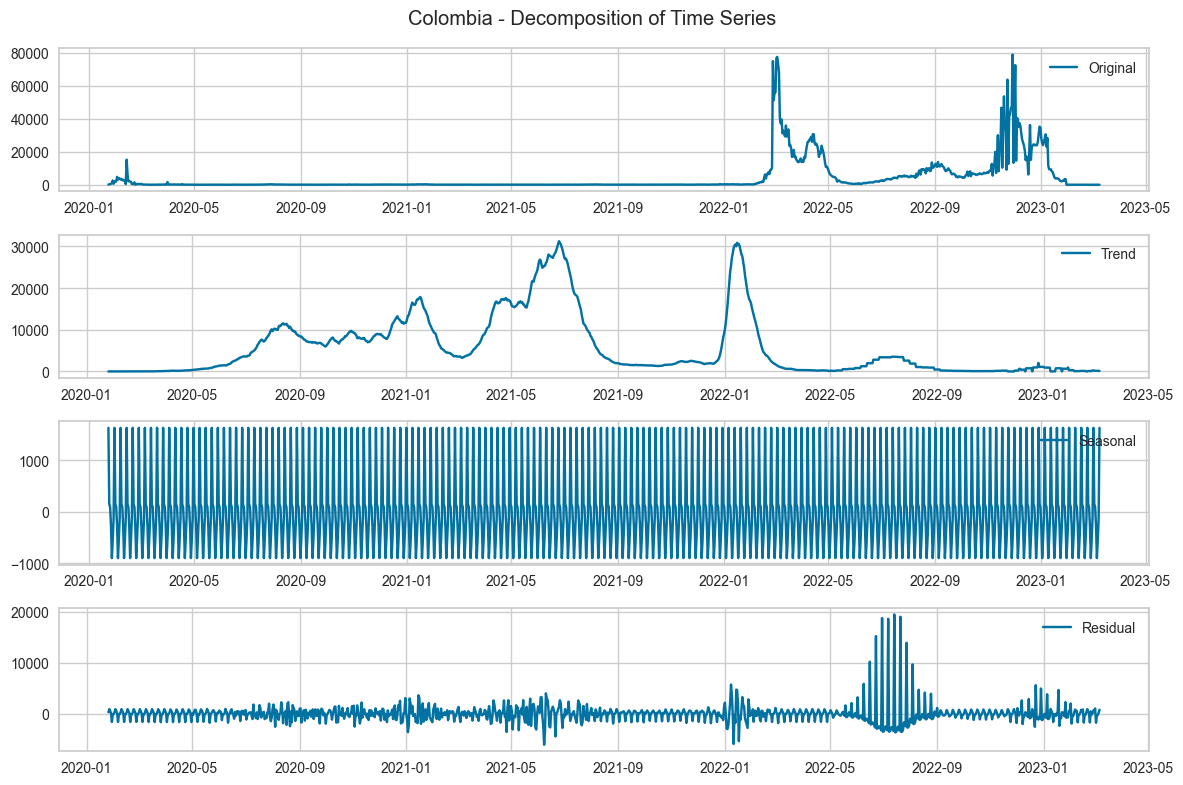

In [100]:
plot_seasonal_decompose(df_confirmed_subset, 'Colombia')

#### Fourier Transforms

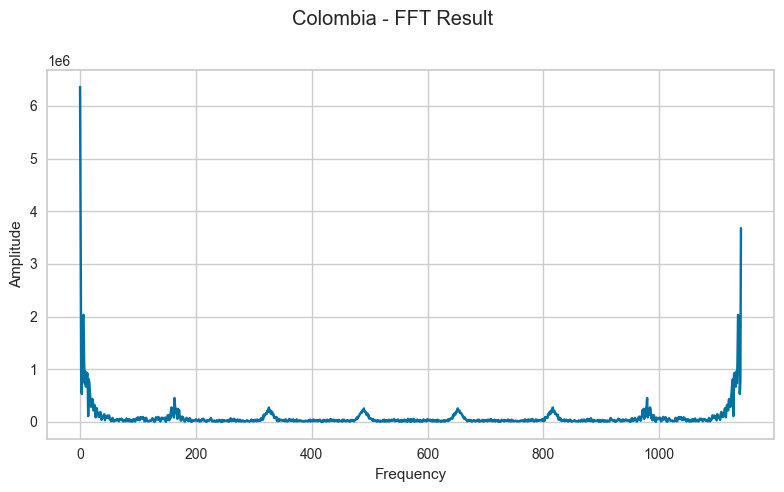

In [94]:
plot_fft_decompose(df_confirmed_subset, 'Colombia')

### Uruguay 
#### Boxplots by time feature

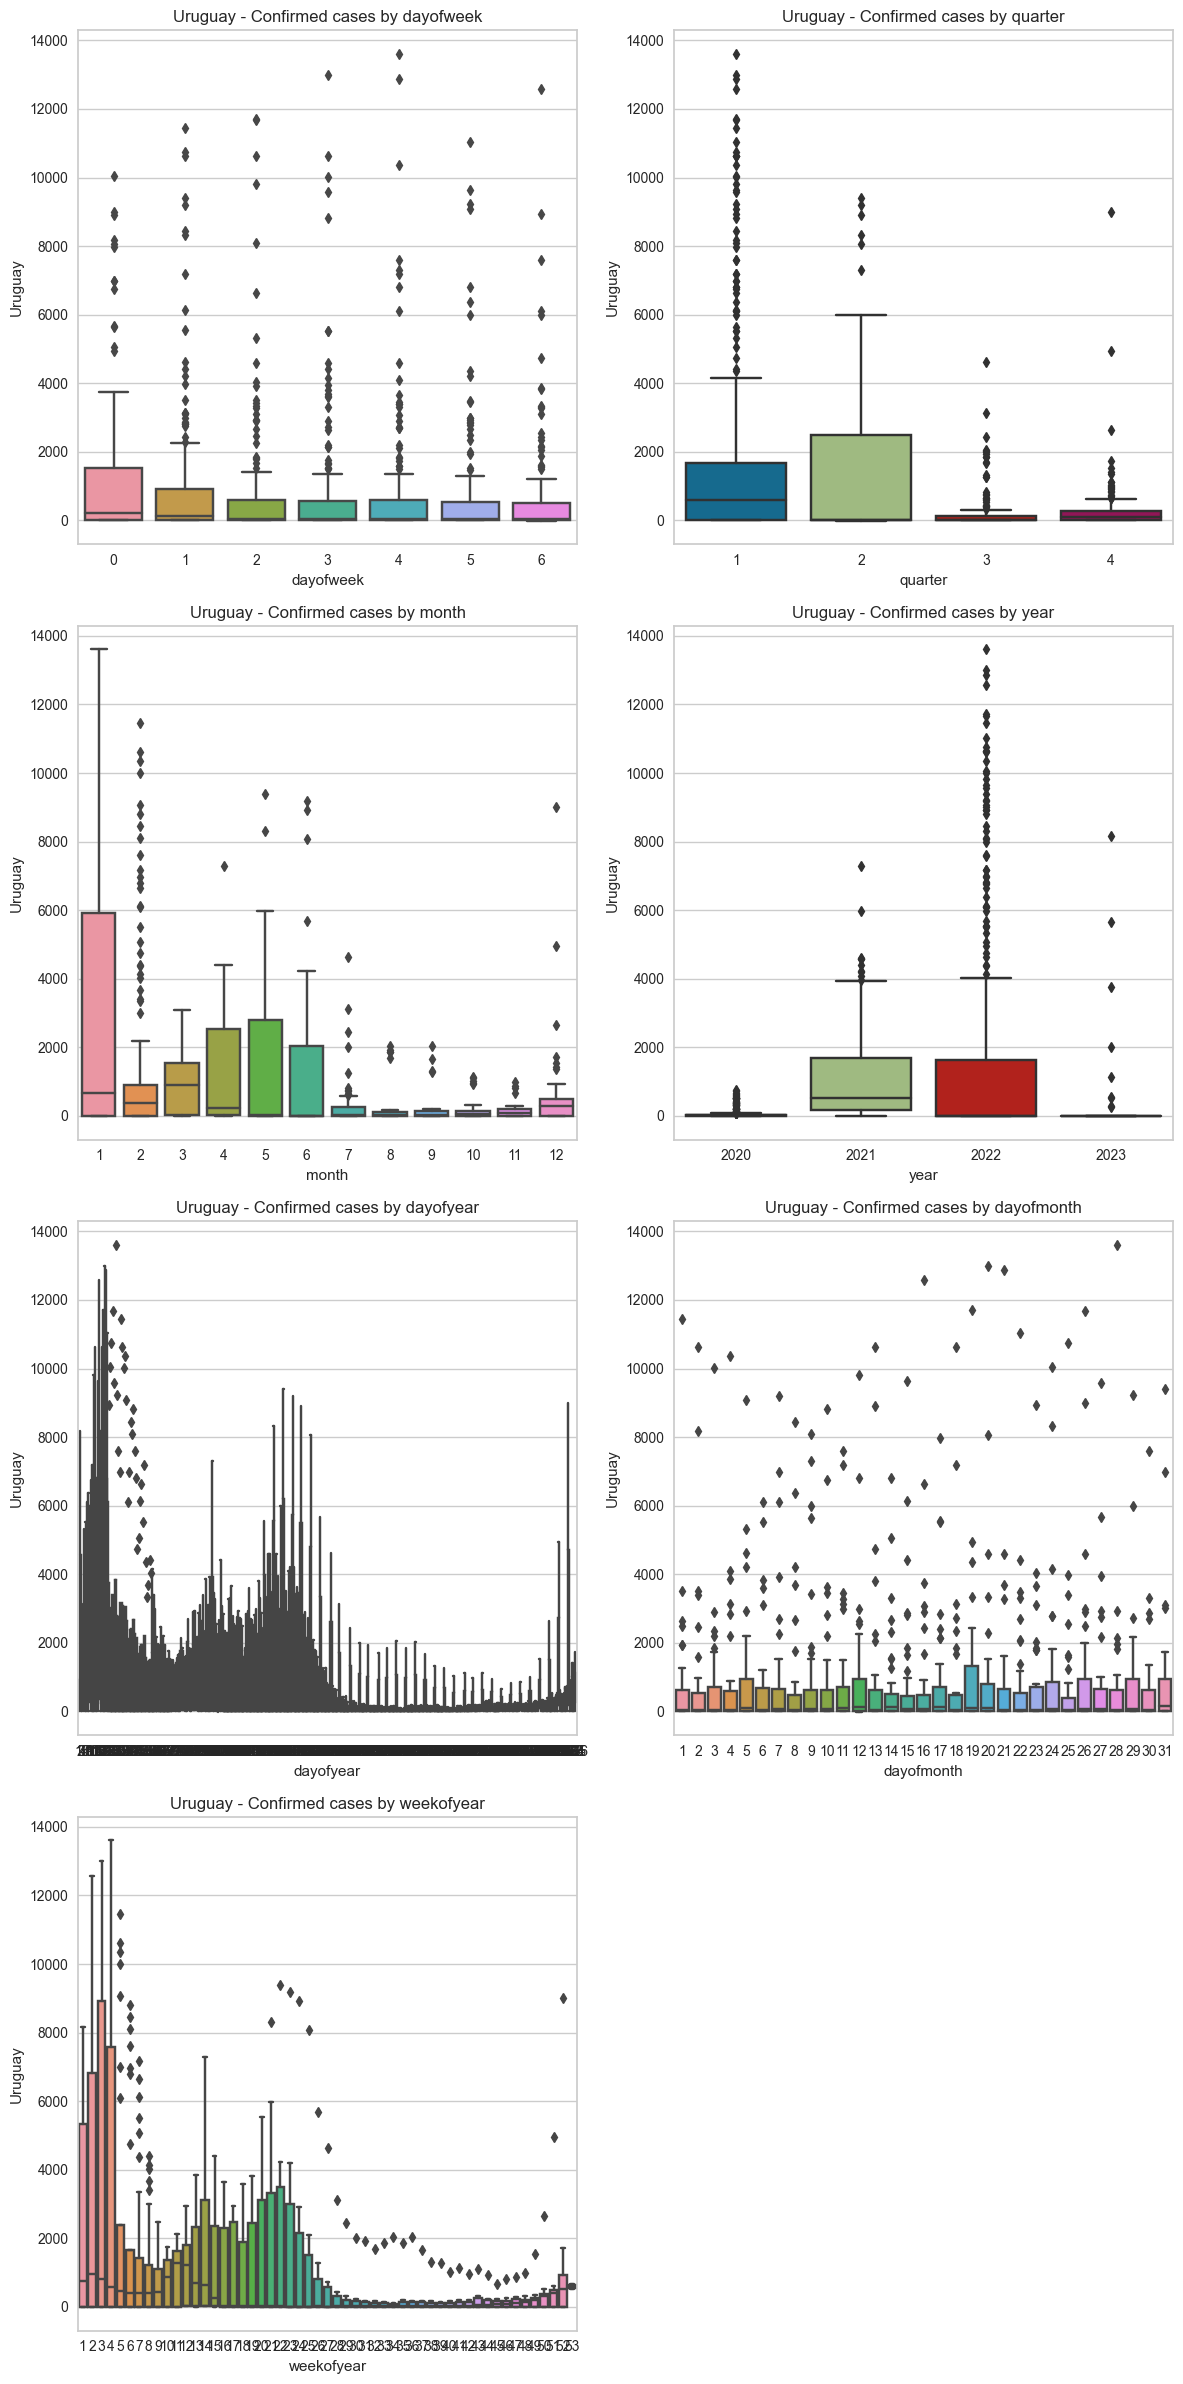

In [69]:
box_plot_by_country_feature(df_confirmed_subset, 'Uruguay')

#### Seasonal decompose

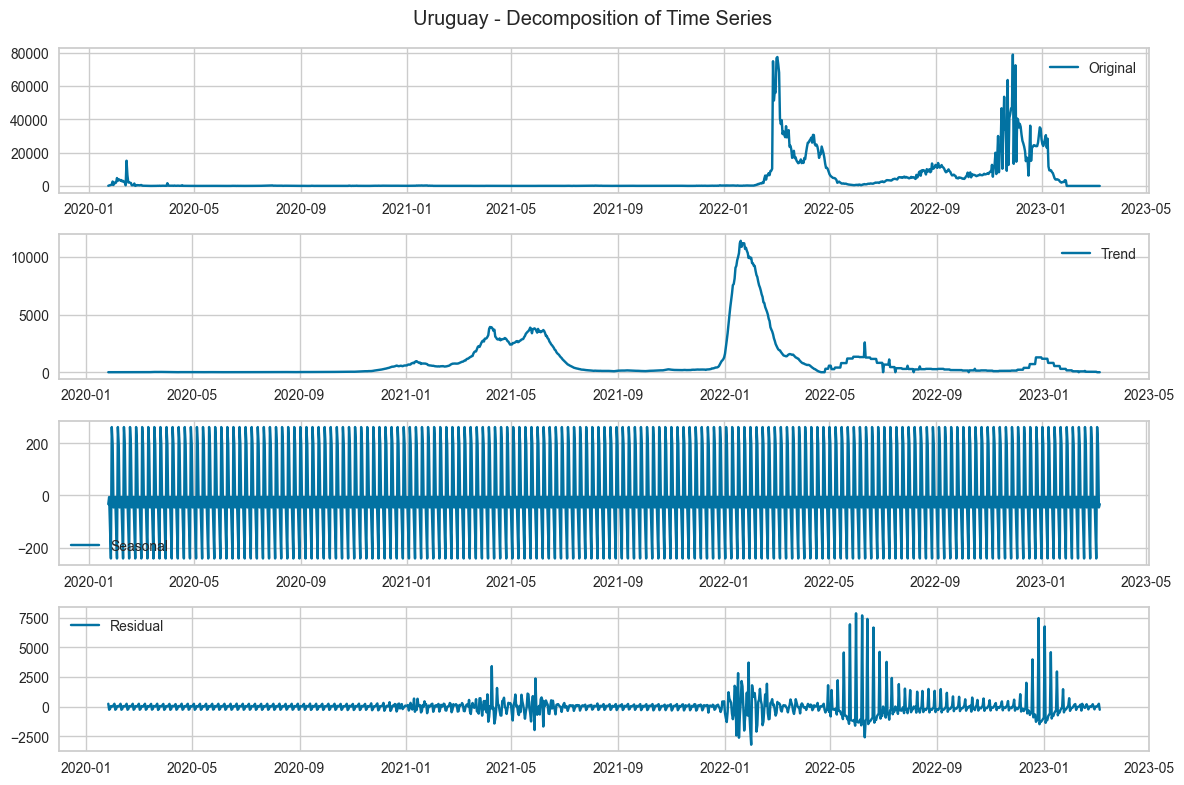

In [78]:
plot_seasonal_decompose(df_confirmed_subset, 'Uruguay')

#### Fourier Transforms

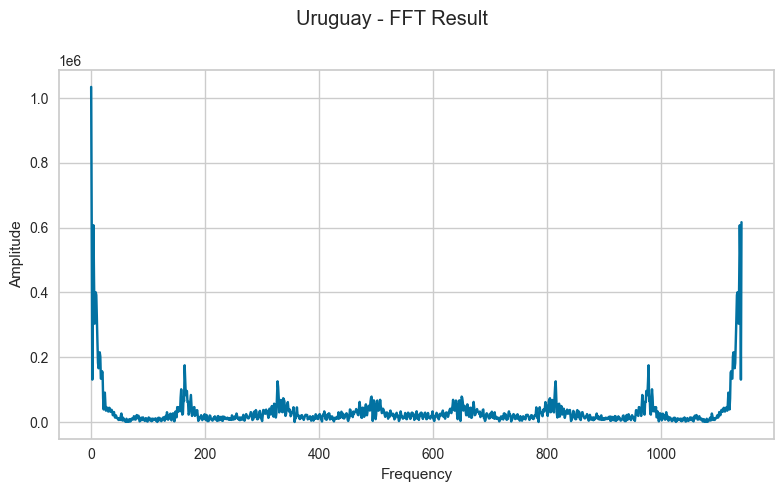

In [96]:
plot_fft_decompose(df_confirmed_subset, 'Uruguay')

### Taiwan
#### Boxplots by time feature

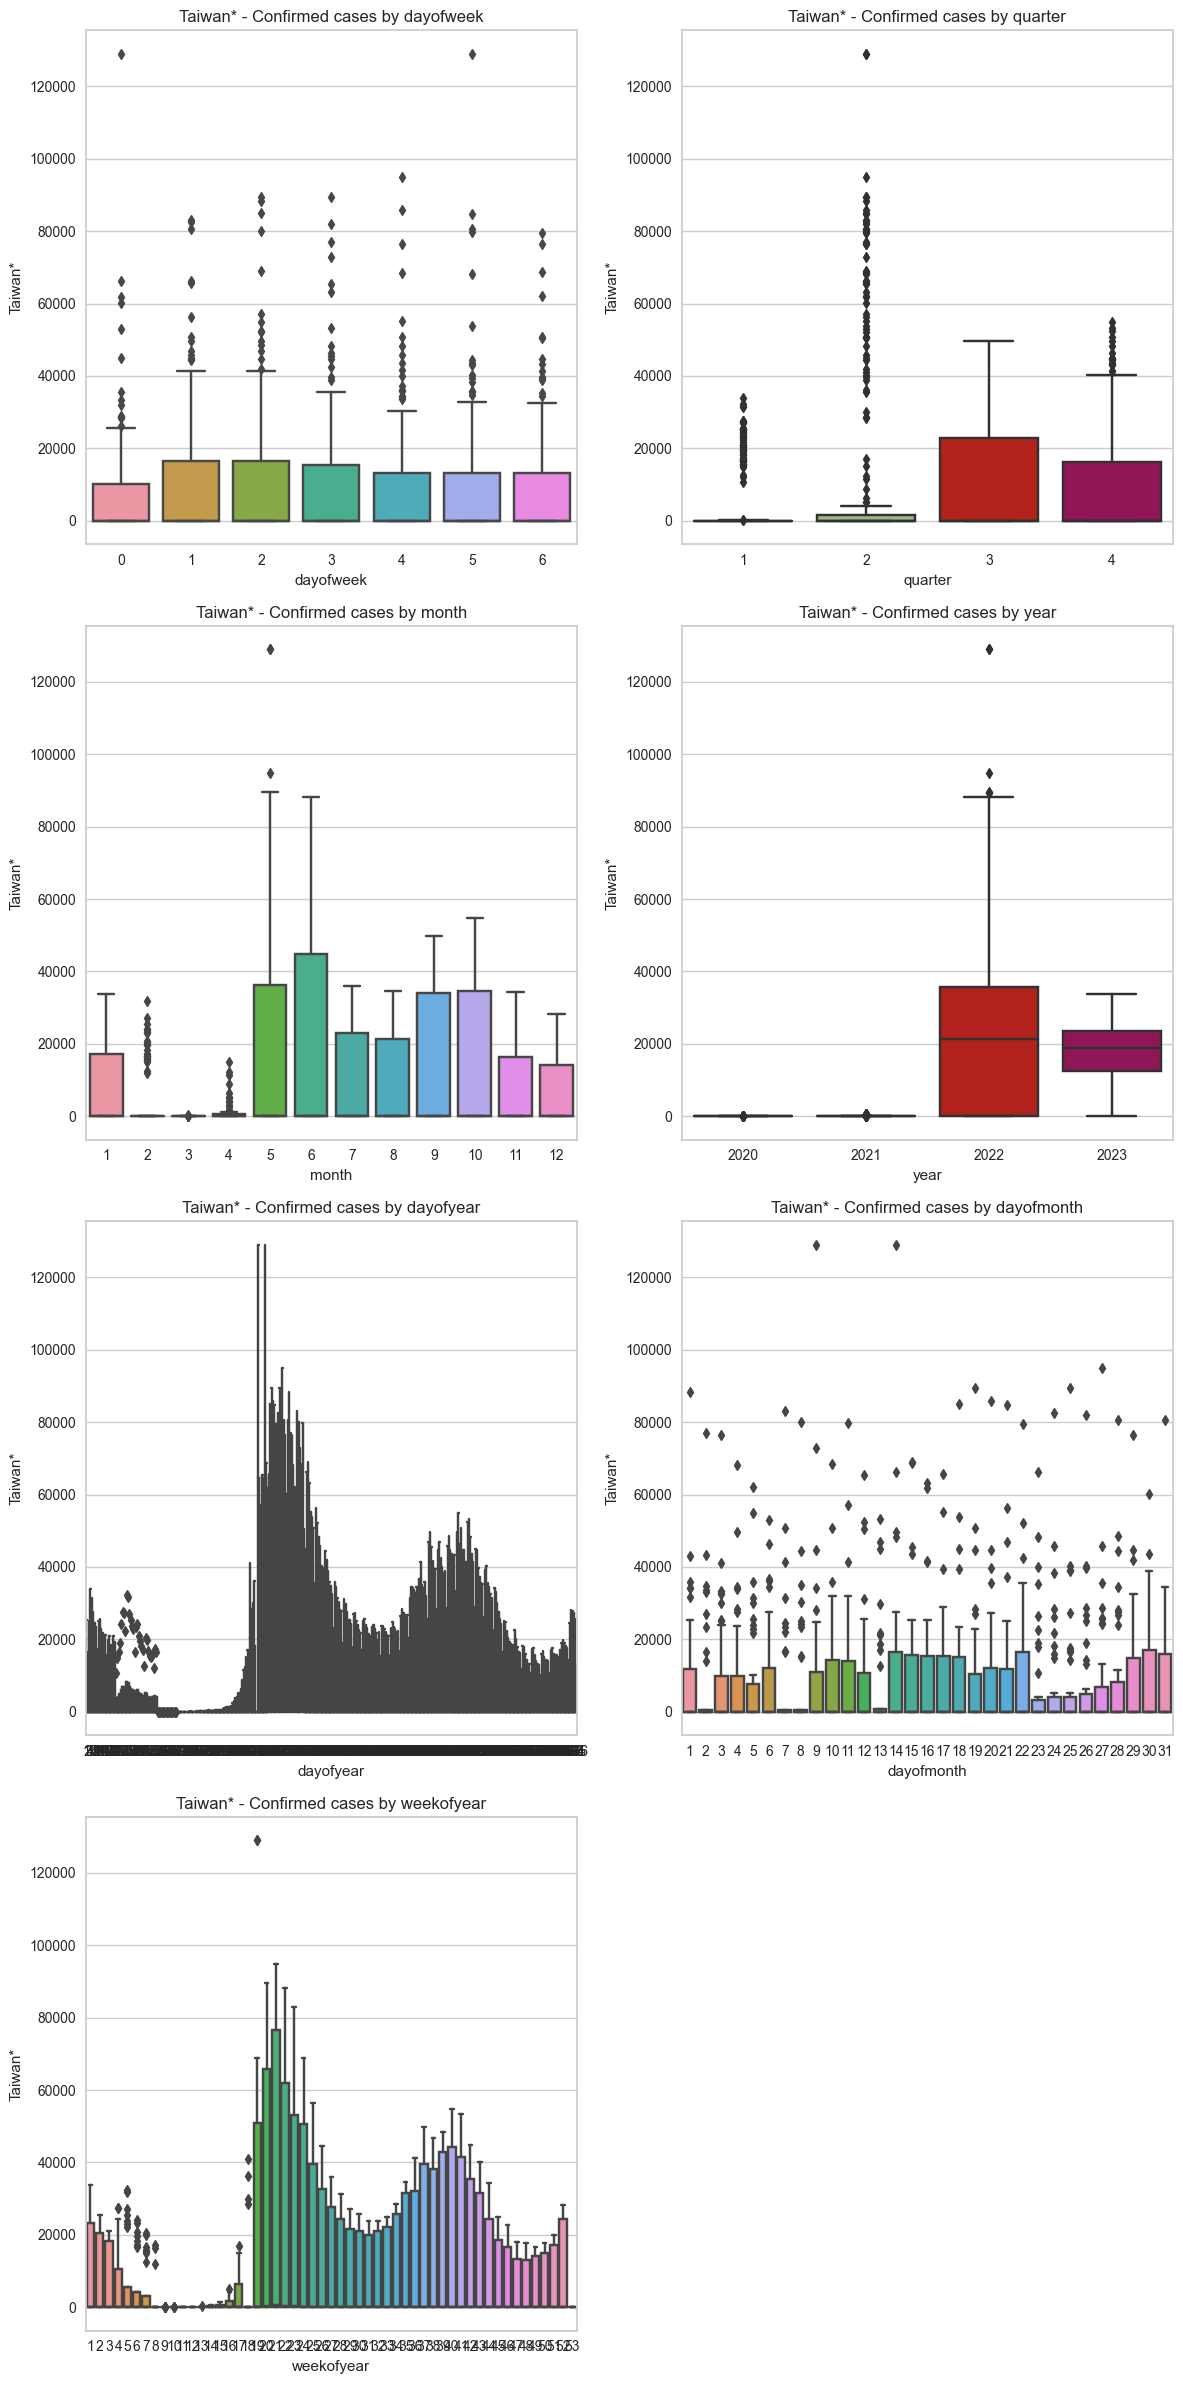

In [68]:
box_plot_by_country_feature(df_confirmed_subset, 'Taiwan*')

#### Seasonal decompose

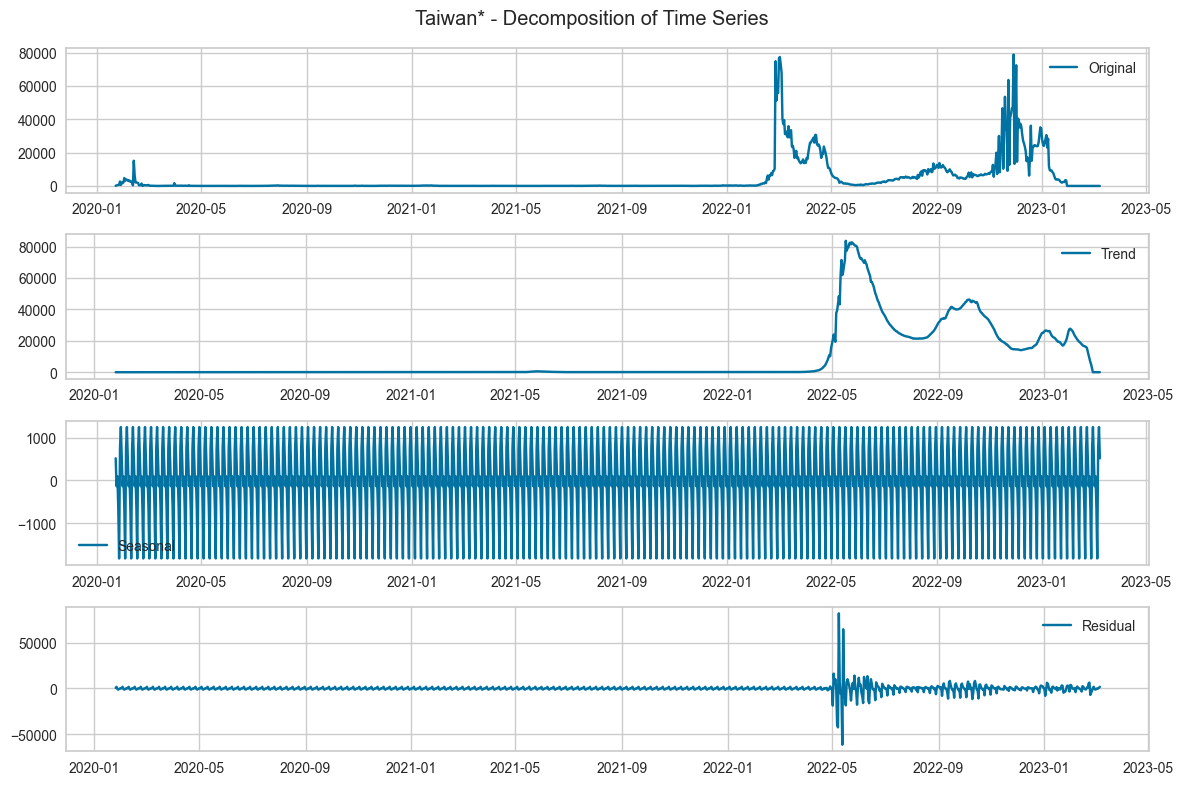

In [79]:
plot_seasonal_decompose(df_confirmed_subset, 'Taiwan*')

#### Fourier Transforms

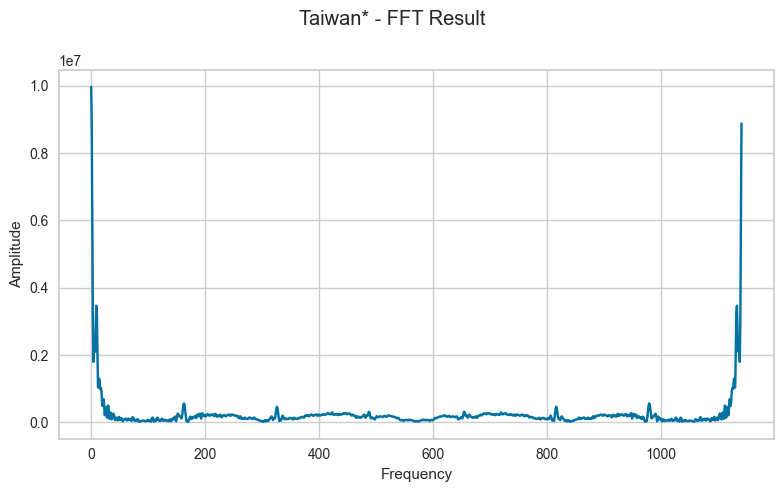

In [95]:
plot_fft_decompose(df_confirmed_subset, 'Taiwan*')